In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
NUM_ITER = 20
k = 5000 #use for taking expectation in computing loss

In [3]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [4]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    S_new_train = S_new[:int(0.8*k)]
    S_new_test = S_new[int(0.8*k):]
    return S_new, S_new_train, S_new_test
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [5]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_dataset()
n = len(S)
m = int(0.8*n) #length of S_train
S_train = S[:m]
S_test = S[m:]
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new, S_new_train, S_new_test = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))

## NN Model

In [6]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 120, (4,4)) #similar to 4-gram
        self.cnn_pep_1 = nn.Conv2d(1, 50, (4,20))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(4690, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [7]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, 1, apt.shape[0], apt.shape[1]))).cuda() #(1, 1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, 1, pep.shape[0], pep.shape[1]))).cuda() #(1, 1, 8, 20)
    return apt, pep

def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return out

def loss_samples(k, ds='train'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

def prime_loss_samples(k, ds='train'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep)
        pairs.append((x, y, ind, pmf))
    return pairs
    
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = m
    else:
        dset = prime_test_loss_samples
        leng = n-m
    for (apt, pep, ind, pmf) in dset:
        x = apt.cuda()
        y = pep.cuda()
        out = model(x, y)
        if ind == 0:
            factor = (2*leng*get_x_pmf()*pmf)/(1+leng*get_x_pmf()*pmf)
        else:
            factor = 2
        out_is = out.cpu().detach().numpy().flatten()[0] * factor
        outs.append(out_is)
    return np.average(outs)

def plot_loss(train_loss, test_loss, i, j, lamb, gamma):
    plt.plot(train_loss, 'b', label='Train loss')
    plt.plot(test_loss, 'y', label='Test loss')
    plt.title('Loss after ' +  str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_recall(train_recall, test_recall, i, j, lamb, gamma):
    plt.plot(train_recall, 'b', label='Train recall')
    plt.plot(test_recall, 'y', label='Test recall')
    plt.title('Recall after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()
    
def plot_cdf(train_cdf, test_cdf, i, j, lamb, gamma):
    plt.plot(train_cdf, 'b', label='Train CDF')
    plt.plot(test_cdf, 'y', label='Test CDF')
    plt.title('CDF after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

In [8]:
train_loss_samples = loss_samples(k, 'train')
test_loss_samples = loss_samples(k, 'test')
prime_train_loss_samples = prime_loss_samples(k, 'train')
prime_test_loss_samples = prime_loss_samples(k, 'test')

## SGD

In [9]:
def sgd(lamb=1e28, #hyperparam
        gamma=1e-3): #step size
    
    optim = SGD(model.parameters(), lr=gamma)

    for j in range(NUM_ITER):
        
        train_losses = []
        train_recalls = []
        train_recall_outputs = [] 

        test_losses = []
        test_recalls = []
        test_recall_outputs = []

        new_outputs = []

        train_correct = 0
        test_correct = 0
        
        for i, ele in enumerate(tqdm.tqdm(train_ds)):
            #ele = (x, y, (x', y'), indicator)
            if i == 0:
                continue
            model.train()
            optim.zero_grad() 
            x, y = convert(ele[0], ele[1]) #sample x,y from S_train
            out = update(x, y) #get S_train output/score
            log_out = torch.log(out) 
            train_score = out.cpu().detach().numpy().flatten()[0] 
            if train_score > 0.6:
                train_correct += 1 
            train_recall_outputs.append(train_score) 

            optim.zero_grad() 
            y_pmf = get_y_pmf(ele[2][1])
            x_prime, y_prime = convert(ele[2][0], ele[2][1]) #sample x', y' from S_prime_train
            const = ele[3] #indicator
            out_prime = update(x_prime, y_prime) #get score from S_prime_train
            if const == 0:
                factor = (2*m*get_x_pmf()*y_pmf)/(1+m*get_x_pmf()*y_pmf)
            else:
                factor = 2
            out_prime = out_prime*factor #adjust for IS
            #print("Obj first part: ", out_prime.cpu().detach().numpy().flatten()[0]*lamb*const)
            #print("Obj second part: ", log_out.cpu().detach().numpy().flatten()[0])
            (lamb*const*out_prime - log_out).backward(retain_graph=True) 
            optim.step()

            with torch.no_grad():
                model.eval()
            x_test, y_test = convert(S_test[i%(n-m)][0], S_test[i%(n-m)][1]) #sample x,y from test set
            test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0]
            test_recall_outputs.append(test_score) 
            if test_score > 0.6:
                test_correct += 1 

            #generate 10 unseen examples from S_new as compared 1 example from S_train/S_test for cdfs
            for x, y in S_new[10*i:10*(i+1)]:
                x_new, y_new = convert(x, y) #generate unseen x'' and y'' from S_new
                new_score = model(x_new, y_new).cpu().detach().numpy().flatten()[0] #get unknown score
                new_outputs.append(new_score)

            if i % 5000 == 0:
                train_loss = lamb*get_out_prime("train") - get_log_out('train') #training loss
                #print("Train loss first part: ", lamb*get_out_prime("train"))
                #print("Train loss second part: ", get_log_out('train'))
                test_loss = (m/(n-m))*lamb*get_out_prime("test") - get_log_out('test') #test loss
                #print("Test loss first part: ", lamb*get_out_prime("test"))
                #print("Test loss second part: ", get_log_out('test'))
                train_losses.append(train_loss)
                test_losses.append(test_loss)

                train_recall = 100*train_correct/i #training recall
                train_recalls.append(train_recall) 
                test_recall = 100*test_correct/i #test recall
                test_recalls.append(test_recall)
                if i > 1000:
                    train_score = np.asarray(new_outputs[-10000:] + train_recall_outputs[-1000:]) 
                    test_score = np.asarray(new_outputs[-10000:] + test_recall_outputs[-1000:])
                else:
                    train_score = np.asarray(new_outputs + train_recall_outputs) #combine train and unknown scores
                    test_score = np.asarray(new_outputs + test_recall_outputs) #combibne test and unknown scores
                train_cdf = np.cumsum(train_score)/np.sum(train_score) #train cdf
                test_cdf = np.cumsum(test_score)/np.sum(test_score) #test cdf


            if i % 50000 == 0:
#                 torch.save({'epoch': j,
#                             'model_state_dict': model.state_dict(),
#                             'optimizer_state_dict': optimizer.state_dict()}, '../models/model.pth')
                plot_recall(train_recalls, test_recalls, i, j, lamb, gamma)
                plot_loss(train_losses, test_losses, i, j, lamb, gamma)
                plot_cdf(train_cdf, test_cdf, i, j, lamb, gamma)
                print("New score: ", np.average(new_outputs[-50:]))
                print("Train score: ", np.average(train_score[-50:]))
                print("Test score: ", np.average(test_score[-50:]))

## Hyperparameter tuning

In [10]:
gammas = [1e-3]
lambdas = [10]

 11%|█         | 49998/473047 [1:28:00<5:02:24, 23.32it/s]   

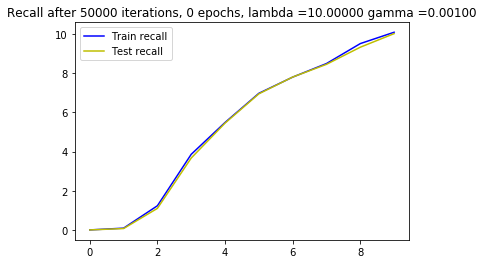

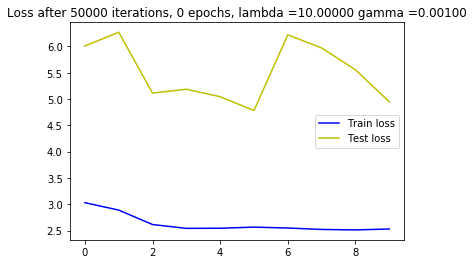

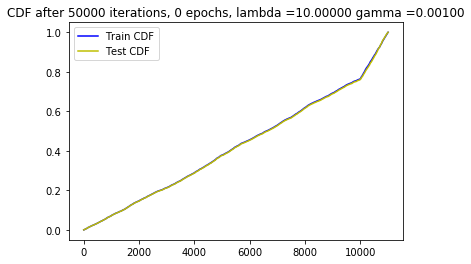

 11%|█         | 50003/473047 [1:28:52<533:59:08,  4.54s/it]

New score:  0.08371769
Train score:  0.20660388
Test score:  0.23167185


 21%|██        | 99997/473047 [2:39:20<5:21:26, 19.34it/s]   

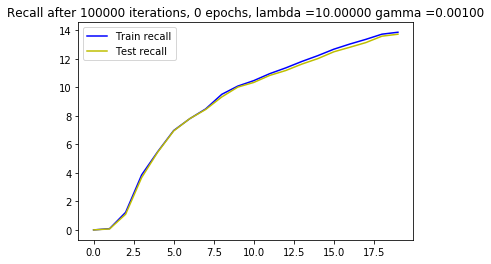

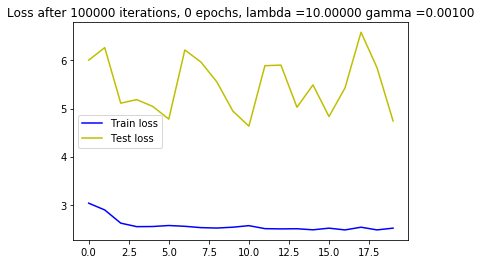

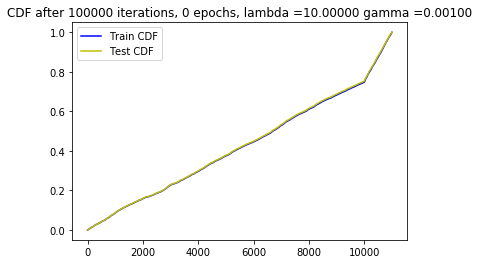

 21%|██        | 100002/473047 [2:40:01<335:16:50,  3.24s/it]

New score:  0.050460774
Train score:  0.3258074
Test score:  0.20989351


 32%|███▏      | 150000/473047 [3:51:10<1:56:32, 46.20it/s]   

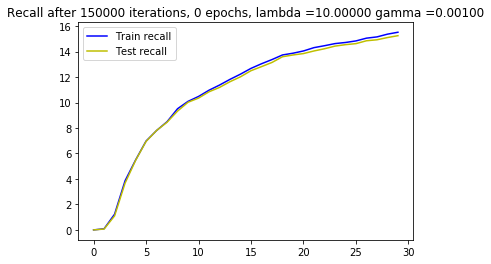

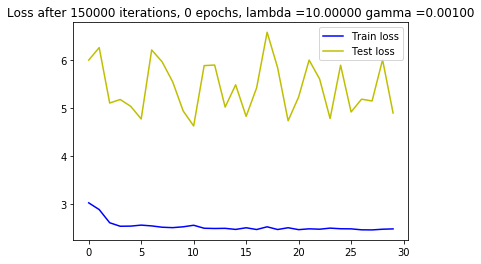

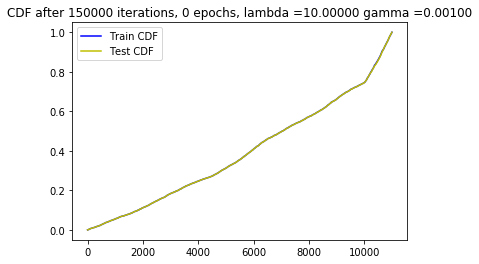

 32%|███▏      | 150002/473047 [3:51:56<1121:37:11, 12.50s/it]

New score:  0.07501832
Train score:  0.3916236
Test score:  0.33163232


 42%|████▏     | 199999/473047 [4:58:50<7:03:17, 10.75it/s]   

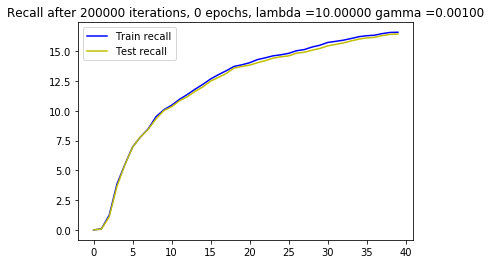

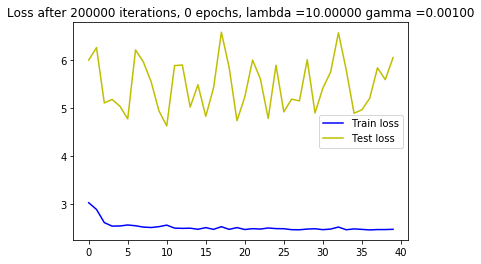

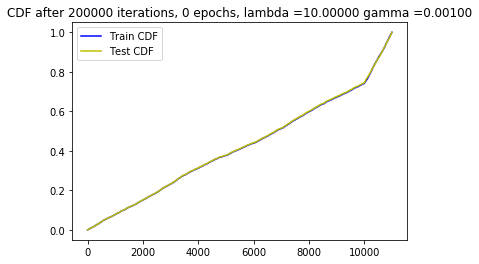

 42%|████▏     | 200003/473047 [4:59:36<465:49:23,  6.14s/it]

New score:  0.089046724
Train score:  0.38407478
Test score:  0.46381554


 53%|█████▎    | 249998/473047 [6:05:50<3:51:28, 16.06it/s]   

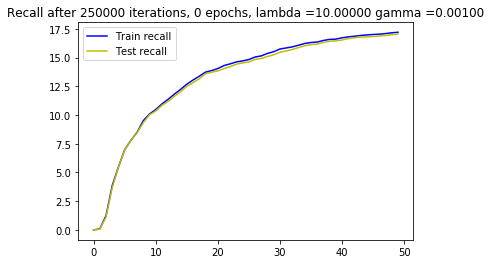

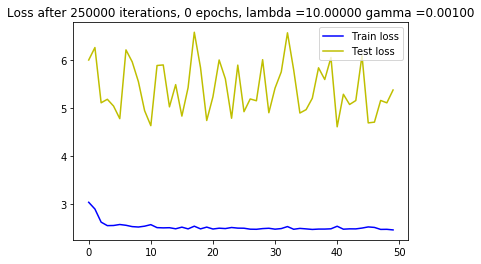

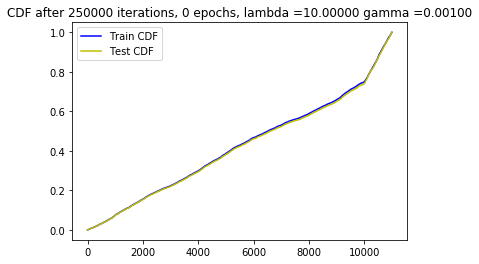

 53%|█████▎    | 250003/473047 [6:06:33<259:09:59,  4.18s/it]

New score:  0.14621684
Train score:  0.28978884
Test score:  0.3717874


 63%|██████▎   | 300000/473047 [7:13:00<40:42, 70.85it/s]     

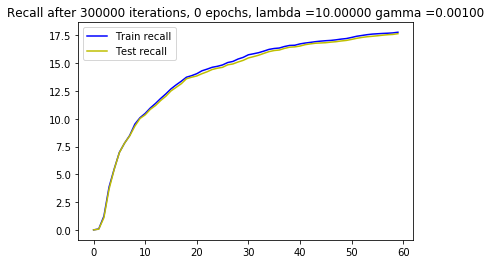

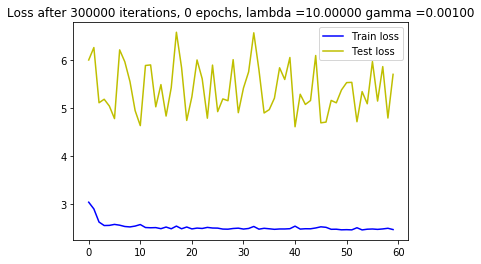

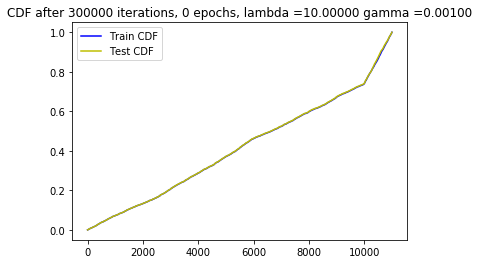

 63%|██████▎   | 300003/473047 [7:13:40<593:19:19, 12.34s/it]

New score:  0.08230223
Train score:  0.43725434
Test score:  0.400275


 74%|███████▍  | 350000/473047 [8:17:40<3:09:14, 10.84it/s]  

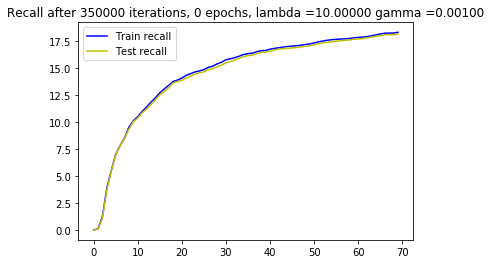

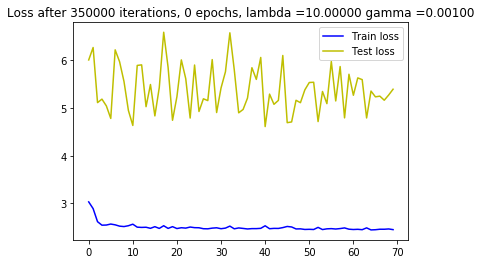

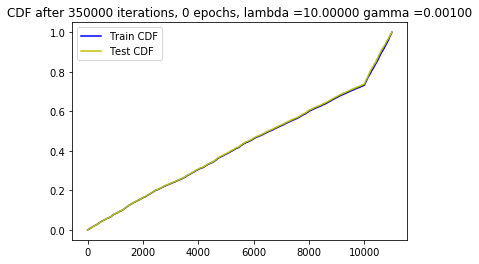

 74%|███████▍  | 350003/473047 [8:18:21<409:58:51, 12.00s/it]

New score:  0.07832464
Train score:  0.54014474
Test score:  0.3103096


 85%|████████▍ | 399999/473047 [9:24:50<1:48:37, 11.21it/s]  

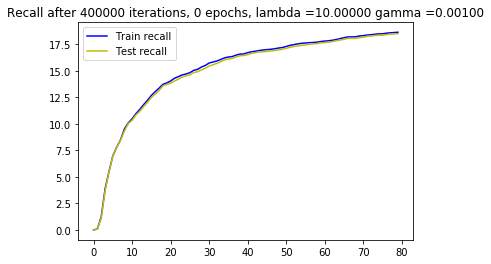

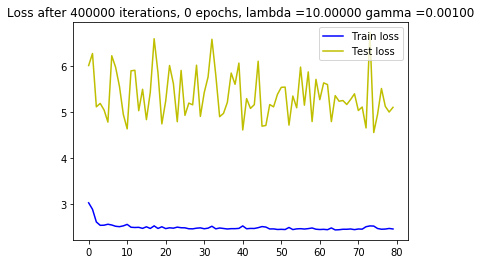

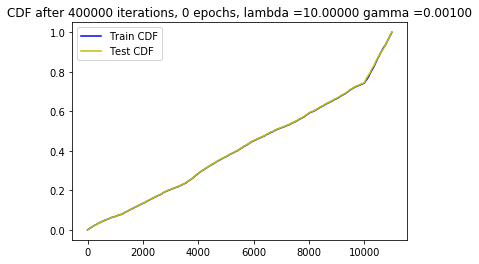

 85%|████████▍ | 400003/473047 [9:25:32<115:57:49,  5.72s/it]

New score:  0.05735947
Train score:  0.3820267
Test score:  0.22473332


 95%|█████████▌| 449999/473047 [10:32:00<27:35, 13.92it/s]   

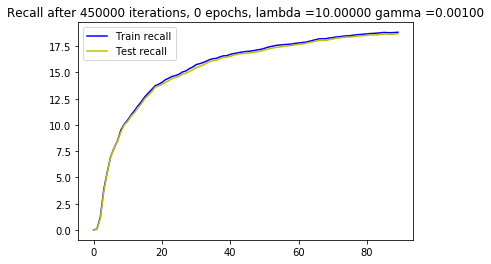

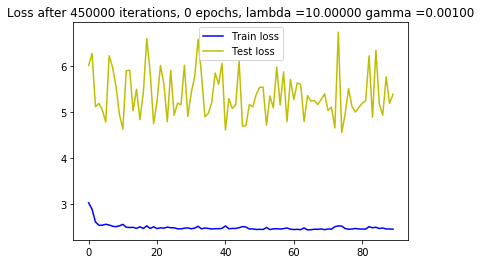

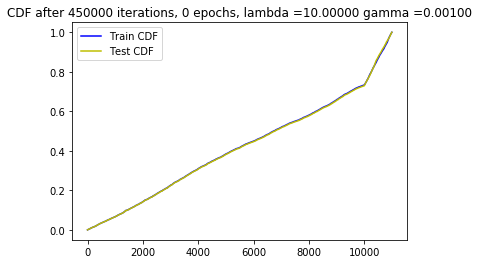

 95%|█████████▌| 450002/473047 [10:32:50<40:39:00,  6.35s/it]

New score:  0.03590425
Train score:  0.33032346
Test score:  0.31252745


 11%|█         | 49992/473047 [1:06:10<1:43:24, 68.19it/s]   

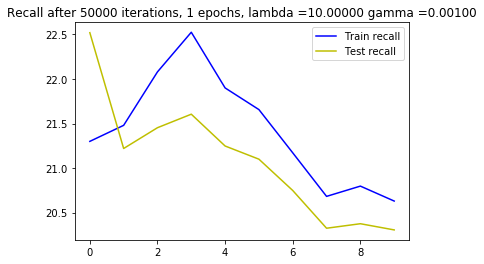

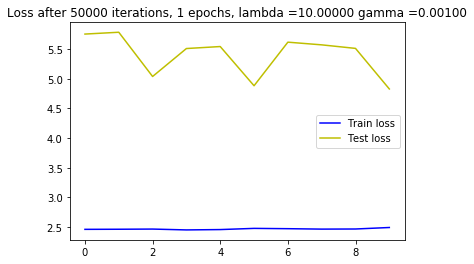

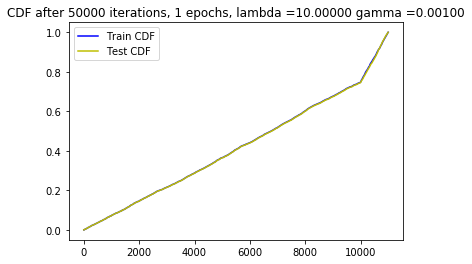

 11%|█         | 50003/473047 [1:06:46<157:43:44,  1.34s/it]

New score:  0.06801186
Train score:  0.24634922
Test score:  0.2550071


 21%|██        | 99999/473047 [2:11:50<10:18:45, 10.05it/s]  

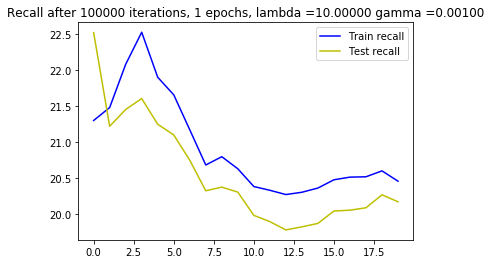

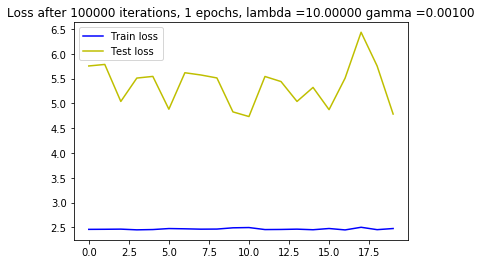

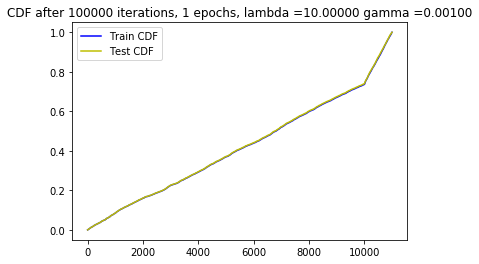

 21%|██        | 100003/473047 [2:12:34<618:14:56,  5.97s/it]

New score:  0.048238304
Train score:  0.3276894
Test score:  0.205351


 32%|███▏      | 149999/473047 [3:20:50<6:41:04, 13.42it/s]   

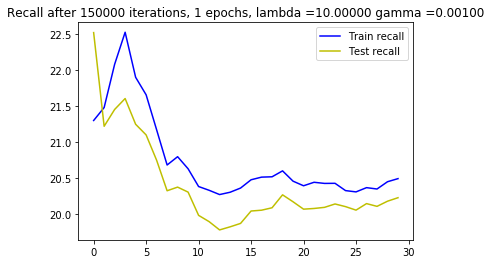

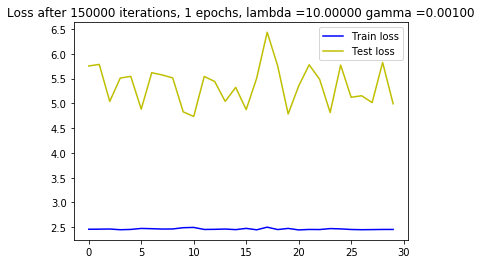

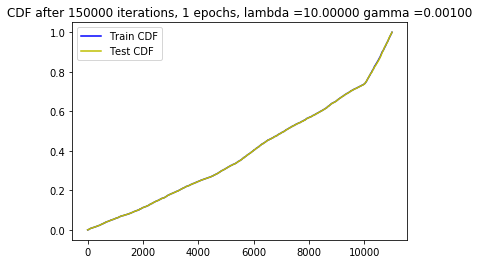

 32%|███▏      | 150003/473047 [3:21:38<566:20:42,  6.31s/it]

New score:  0.07577633
Train score:  0.40527028
Test score:  0.34882954


 42%|████▏     | 199998/473047 [4:32:40<4:13:16, 17.97it/s]   

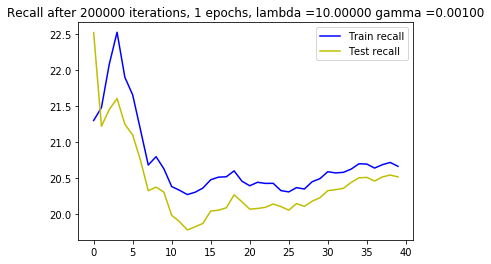

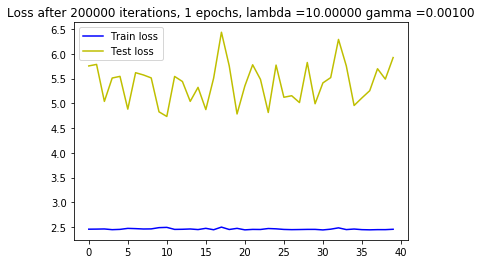

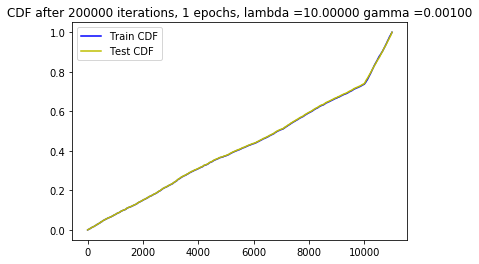

 42%|████▏     | 200002/473047 [4:33:23<327:17:26,  4.32s/it]

New score:  0.08725321
Train score:  0.38343874
Test score:  0.47113594


 53%|█████▎    | 249999/473047 [5:44:20<6:09:49, 10.05it/s]   

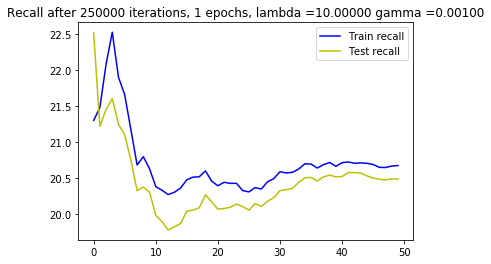

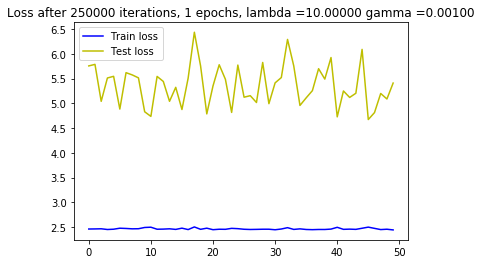

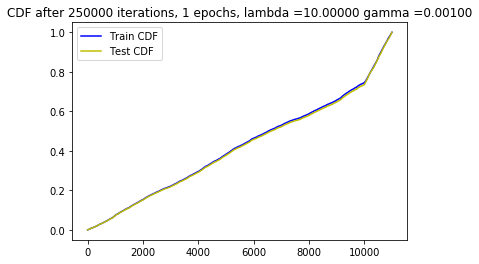

 53%|█████▎    | 250004/473047 [5:45:08<391:26:34,  6.32s/it]

New score:  0.14579394
Train score:  0.29847005
Test score:  0.37890786


 63%|██████▎   | 299999/473047 [6:55:30<4:44:26, 10.14it/s]   

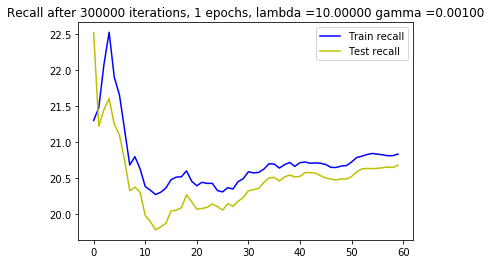

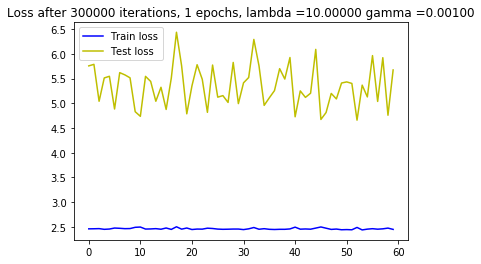

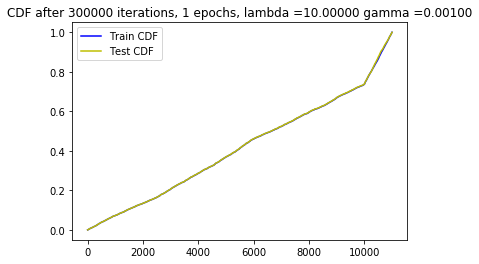

 63%|██████▎   | 300002/473047 [6:56:15<313:04:39,  6.51s/it]

New score:  0.080425136
Train score:  0.45186168
Test score:  0.4158558


 74%|███████▍  | 349996/473047 [8:06:10<1:10:59, 28.89it/s]  

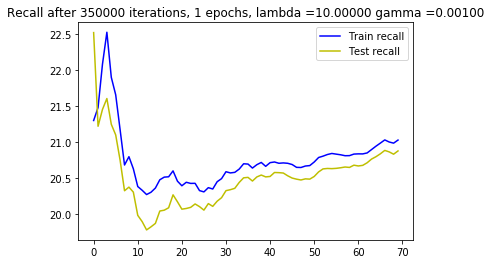

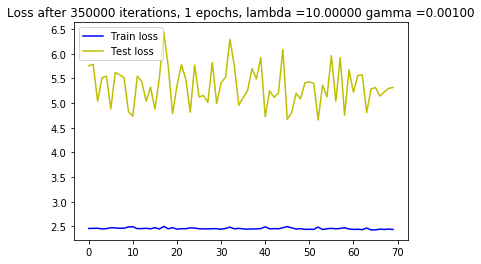

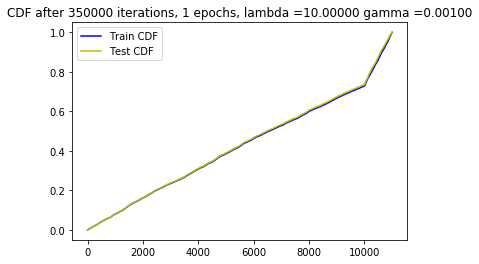

 74%|███████▍  | 350003/473047 [8:06:53<78:46:56,  2.30s/it] 

New score:  0.07418609
Train score:  0.5635424
Test score:  0.30866626


 85%|████████▍ | 399999/473047 [9:17:20<2:01:25, 10.03it/s]  

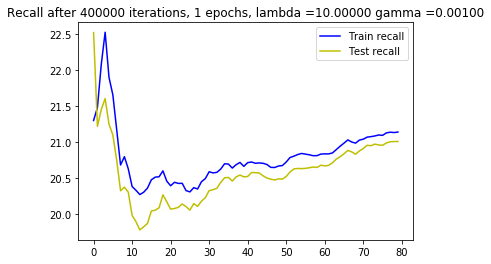

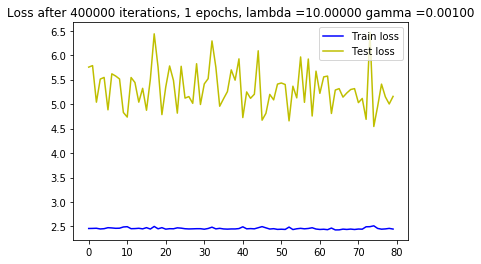

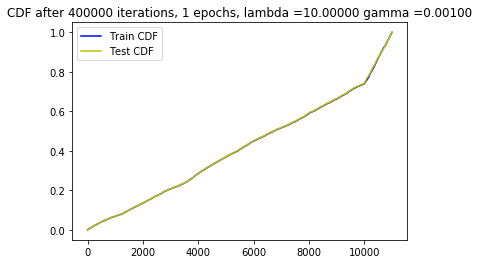

 85%|████████▍ | 400003/473047 [9:17:59<120:25:03,  5.93s/it]

New score:  0.061190248
Train score:  0.39318317
Test score:  0.22880432


 95%|█████████▌| 449999/473047 [10:27:50<21:14, 18.08it/s]    

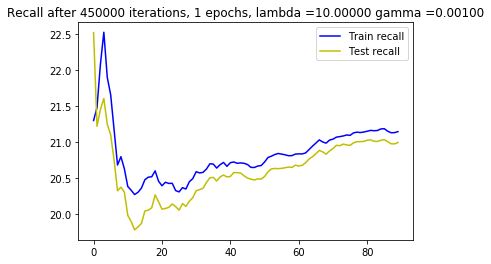

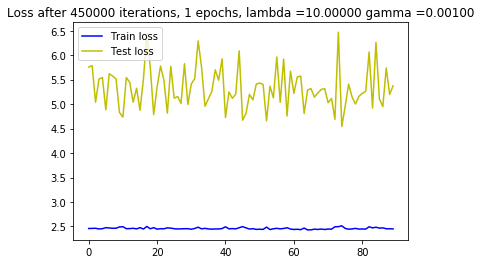

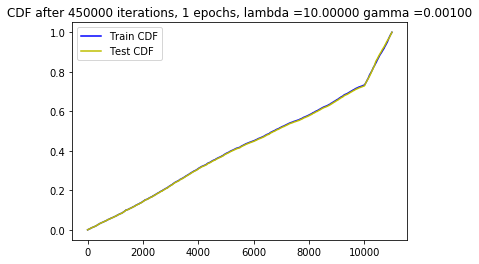

 95%|█████████▌| 450003/473047 [10:28:28<37:33:57,  5.87s/it]

New score:  0.035516966
Train score:  0.34526175
Test score:  0.32939342


 11%|█         | 50000/473047 [1:04:20<11:49:31,  9.94it/s]

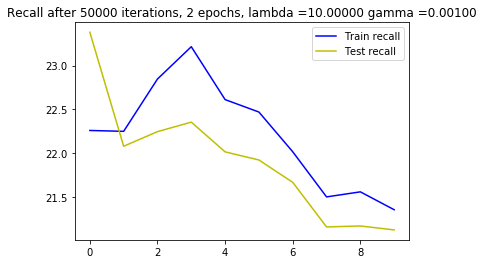

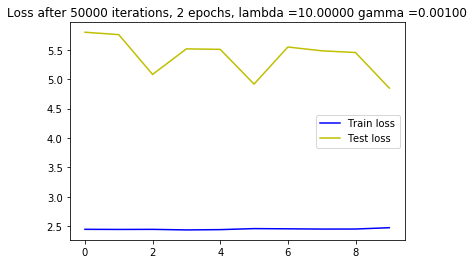

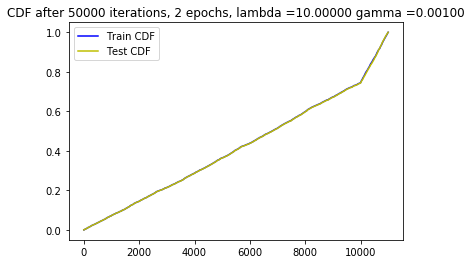

 11%|█         | 50004/473047 [1:05:01<1319:26:54, 11.23s/it]

New score:  0.06812134
Train score:  0.25192726
Test score:  0.26688188


 21%|██        | 99994/473047 [2:08:20<4:05:15, 25.35it/s]   

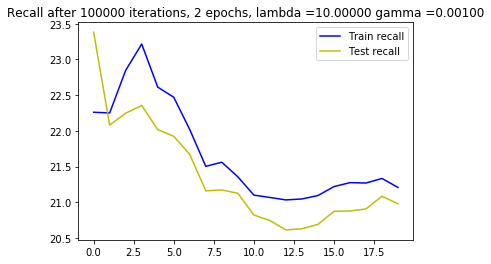

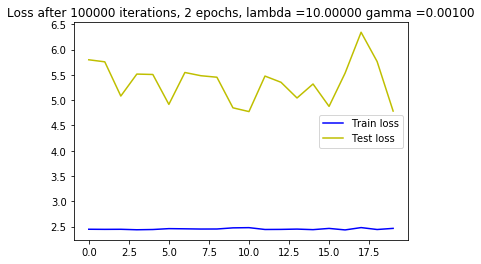

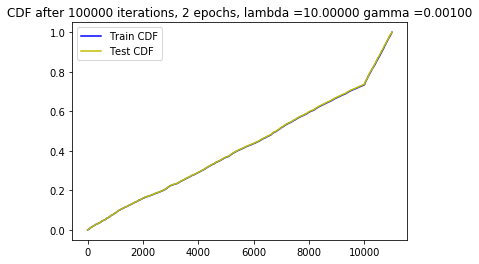

 21%|██        | 100002/473047 [2:09:00<168:06:55,  1.62s/it]

New score:  0.047348663
Train score:  0.32934627
Test score:  0.2087677


 32%|███▏      | 150000/473047 [3:12:30<8:47:58, 10.20it/s]   

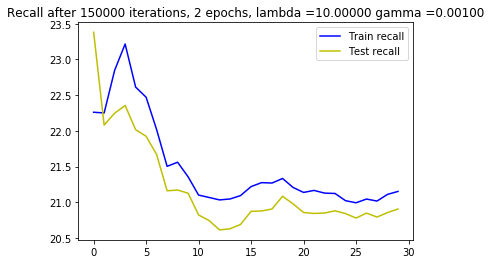

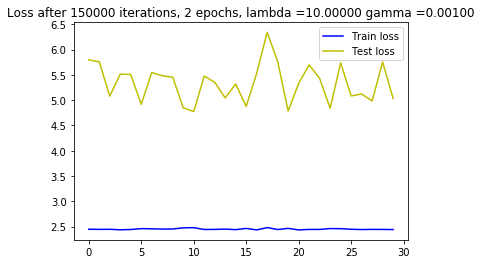

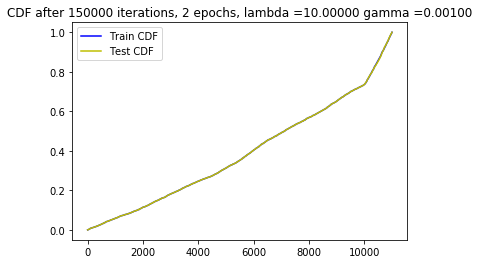

 32%|███▏      | 150002/473047 [3:13:07<999:22:42, 11.14s/it] 

New score:  0.07890982
Train score:  0.4131325
Test score:  0.35803196


 42%|████▏     | 199997/473047 [4:16:40<2:58:05, 25.55it/s]  

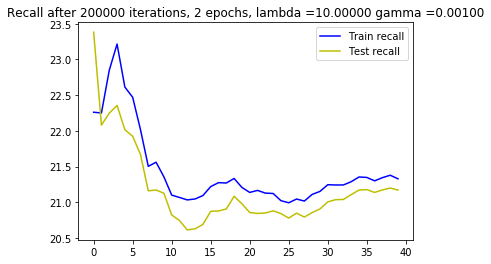

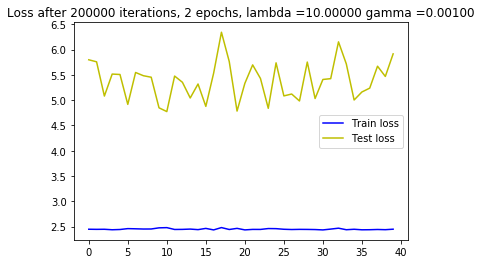

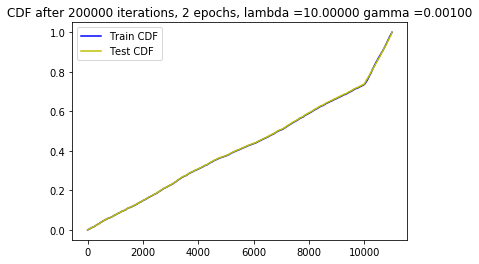

 42%|████▏     | 200002/473047 [4:17:15<206:18:36,  2.72s/it]

New score:  0.08886775
Train score:  0.38847268
Test score:  0.47151202


 53%|█████▎    | 250000/473047 [5:19:49<6:54:38,  8.97it/s]   

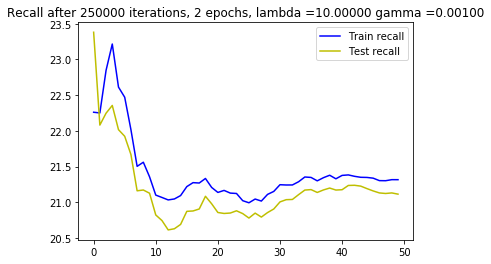

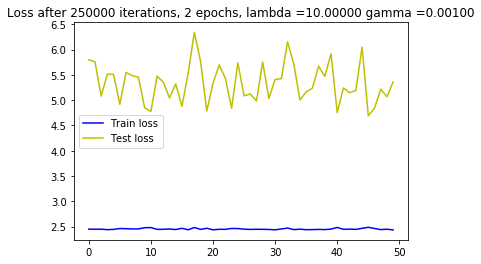

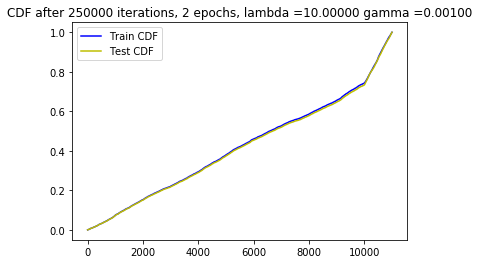

 53%|█████▎    | 250002/473047 [5:20:41<675:08:32, 10.90s/it]

New score:  0.14298986
Train score:  0.29729825
Test score:  0.37635794


 63%|██████▎   | 299997/473047 [6:23:20<2:23:33, 20.09it/s]  

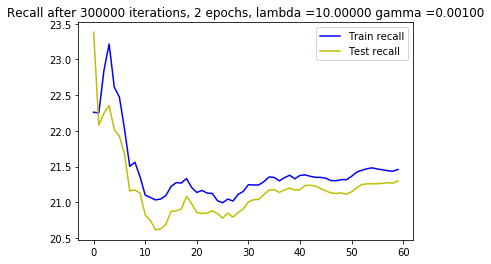

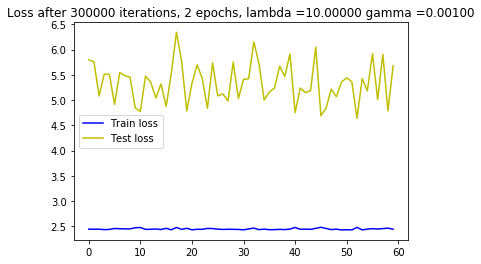

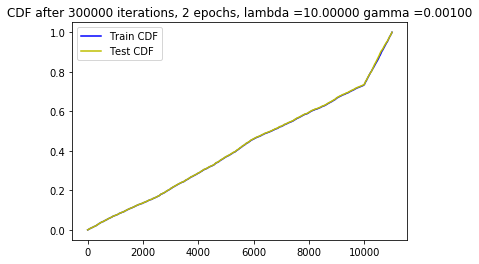

 63%|██████▎   | 300002/473047 [6:23:54<131:34:28,  2.74s/it]

New score:  0.08134098
Train score:  0.461641
Test score:  0.4309958


 74%|███████▍  | 349993/473047 [7:26:50<1:17:40, 26.41it/s]  

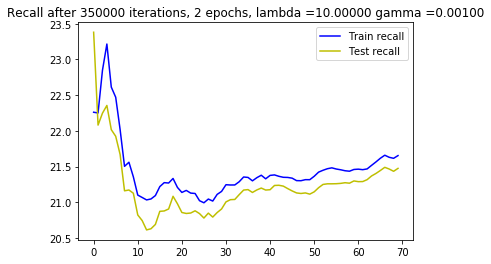

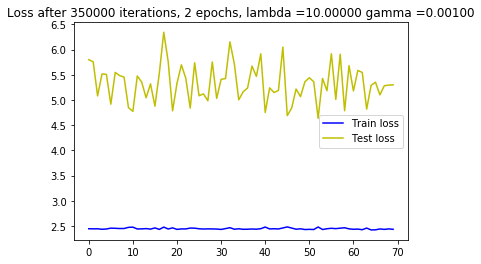

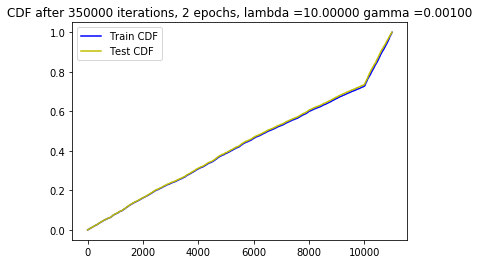

 74%|███████▍  | 350002/473047 [7:27:26<49:41:30,  1.45s/it]

New score:  0.07305699
Train score:  0.56342065
Test score:  0.3109967


 85%|████████▍ | 399999/473047 [8:29:21<1:52:25, 10.83it/s]  

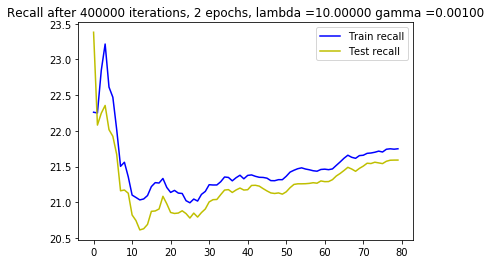

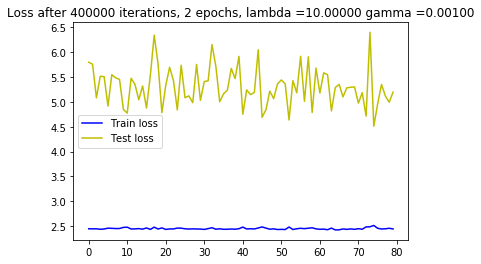

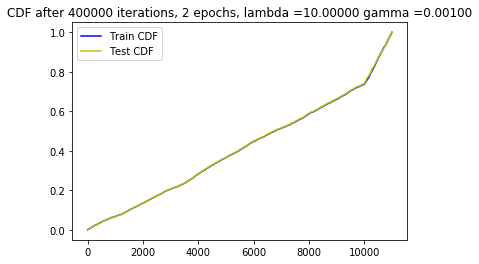

 85%|████████▍ | 400002/473047 [8:29:56<117:11:46,  5.78s/it]

New score:  0.062294293
Train score:  0.39411777
Test score:  0.2372255


 95%|█████████▌| 449998/473047 [9:32:41<25:04, 15.32it/s]    

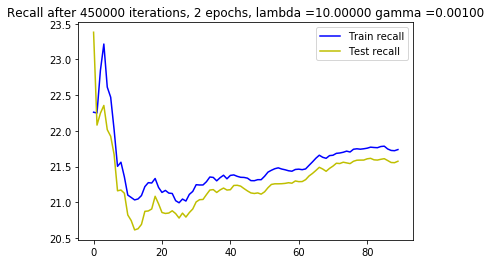

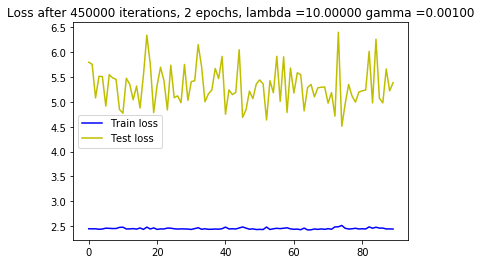

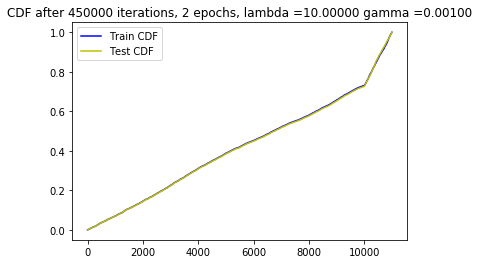

 95%|█████████▌| 450002/473047 [9:33:22<23:23:33,  3.65s/it]

New score:  0.036711484
Train score:  0.35328418
Test score:  0.323345


 11%|█         | 50000/473047 [1:02:40<12:29:20,  9.41it/s]

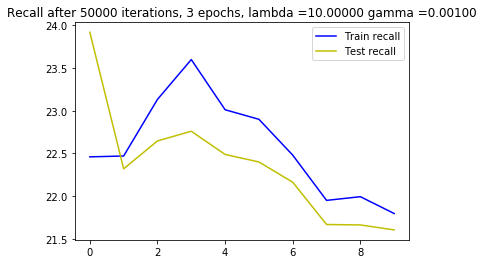

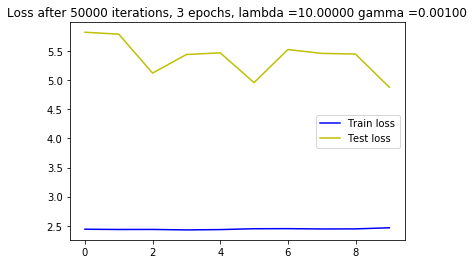

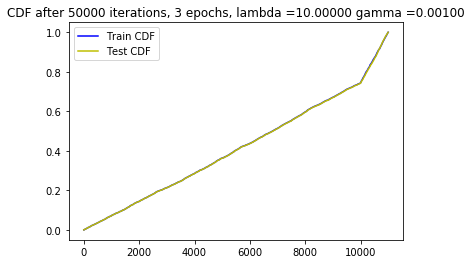

 11%|█         | 50010/473047 [1:03:16<1300:43:32, 11.07s/it]

New score:  0.07107024
Train score:  0.2570302
Test score:  0.2696586


 21%|██        | 100000/473047 [2:05:50<3:05:52, 33.45it/s]  

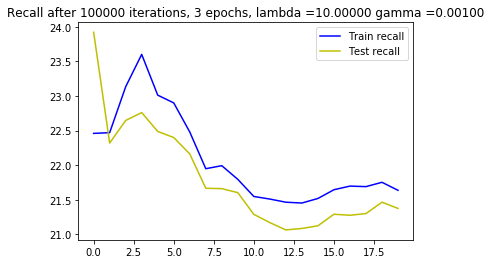

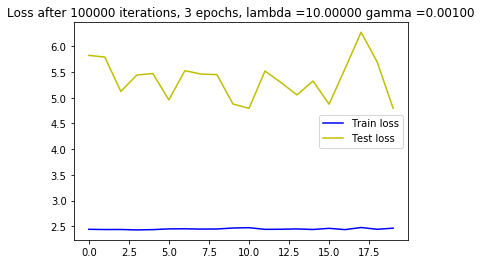

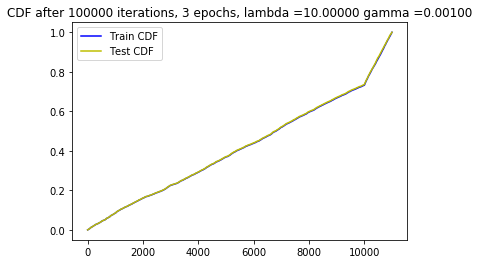

 21%|██        | 100002/473047 [2:06:29<1145:29:55, 11.05s/it]

New score:  0.051484954
Train score:  0.32871476
Test score:  0.21568175


 32%|███▏      | 149999/473047 [3:09:50<3:24:17, 26.35it/s]   

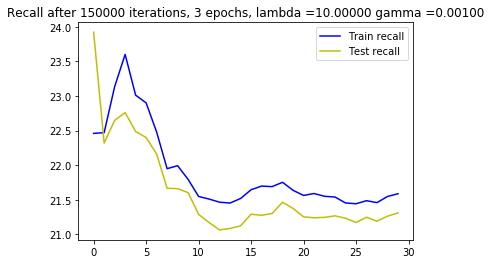

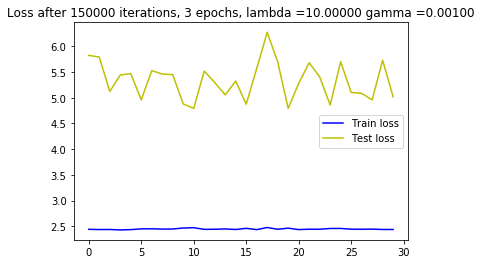

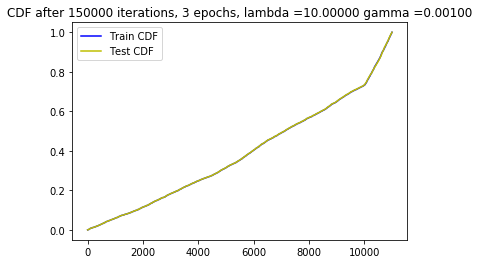

 32%|███▏      | 150002/473047 [3:10:24<492:50:06,  5.49s/it]

New score:  0.08147873
Train score:  0.41777763
Test score:  0.36271408


 42%|████▏     | 200000/473047 [4:13:10<6:56:27, 10.93it/s]   

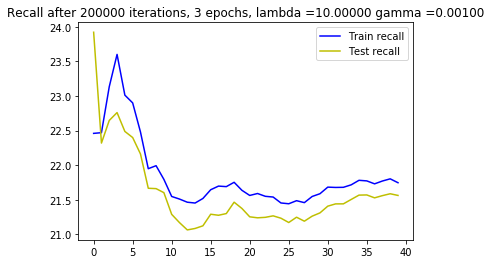

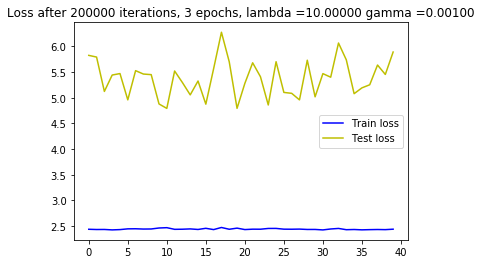

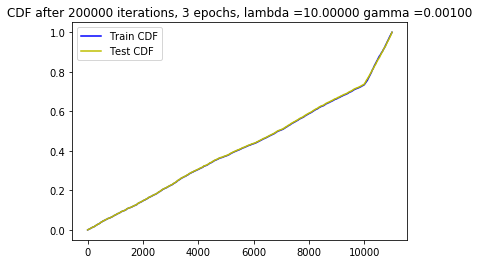

 42%|████▏     | 200002/473047 [4:13:50<862:01:49, 11.37s/it] 

New score:  0.09117561
Train score:  0.3927322
Test score:  0.47657305


 53%|█████▎    | 250000/473047 [5:16:22<6:48:44,  9.09it/s]   

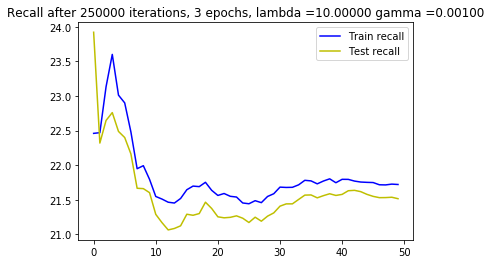

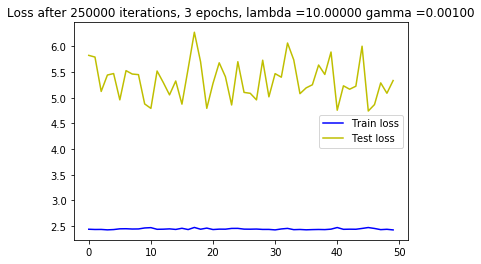

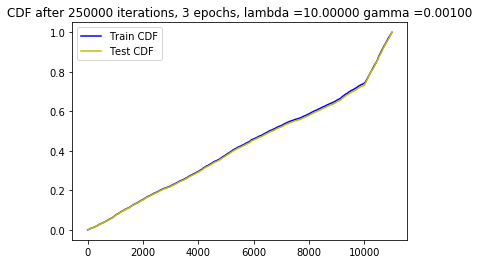

 53%|█████▎    | 250002/473047 [5:17:14<683:07:46, 11.03s/it]

New score:  0.13929957
Train score:  0.29606503
Test score:  0.37153143


 63%|██████▎   | 299992/473047 [5:44:44<35:31, 81.18it/s]    

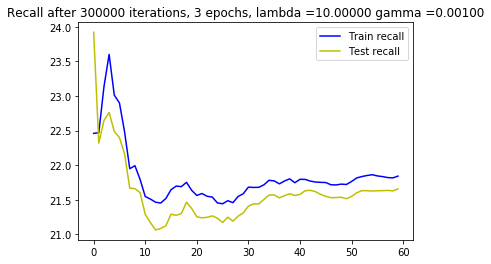

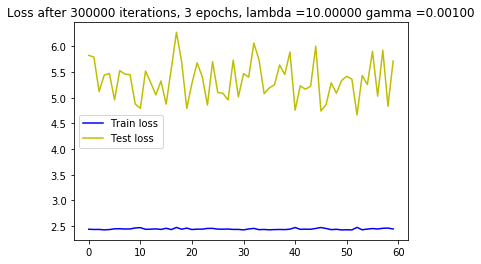

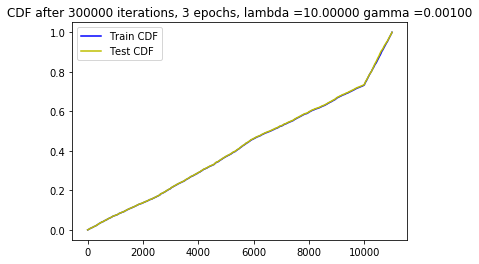

 63%|██████▎   | 300009/473047 [5:44:53<11:21:56,  4.23it/s]

New score:  0.08286961
Train score:  0.4601316
Test score:  0.43522793


 74%|███████▍  | 349995/473047 [5:56:19<25:29, 80.44it/s]   

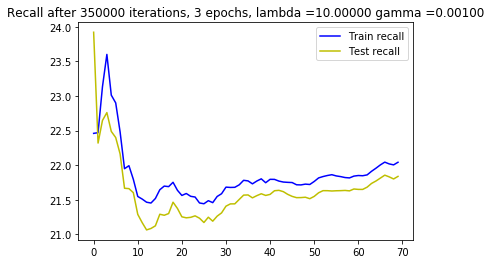

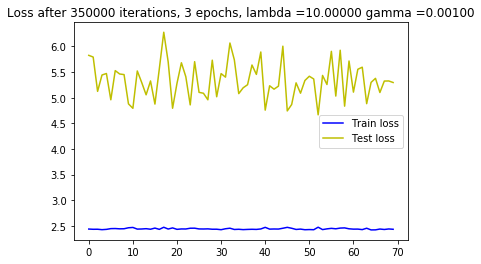

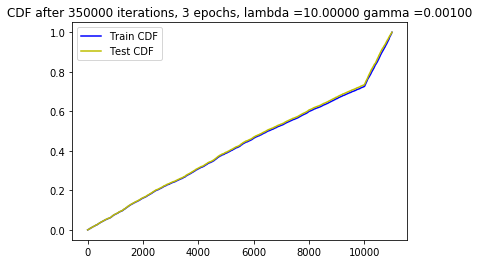

 74%|███████▍  | 350013/473047 [5:56:29<8:06:47,  4.21it/s] 

New score:  0.07240391
Train score:  0.55943424
Test score:  0.30951115


 85%|████████▍ | 399992/473047 [6:07:55<15:14, 79.85it/s]   

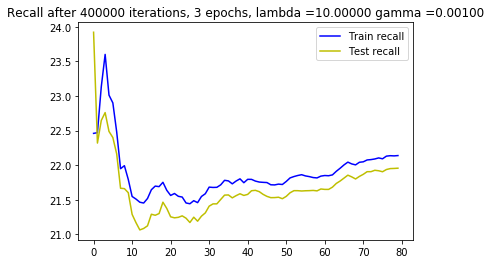

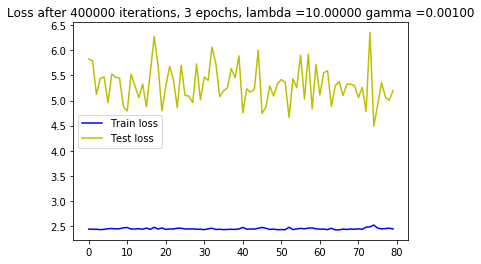

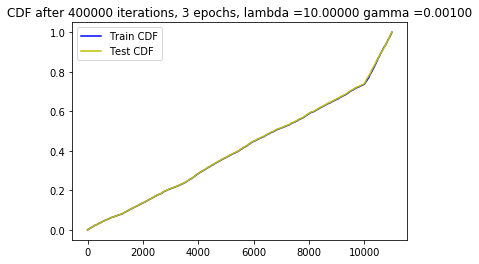

 85%|████████▍ | 400009/473047 [6:08:05<4:47:51,  4.23it/s]

New score:  0.06536408
Train score:  0.40121698
Test score:  0.23701341


 95%|█████████▌| 449995/473047 [6:19:15<04:39, 82.40it/s]  

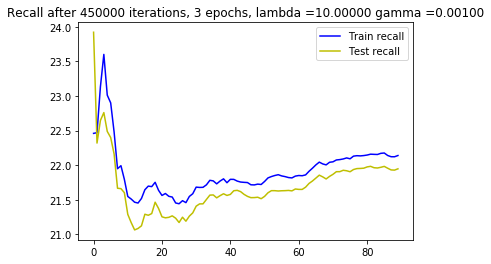

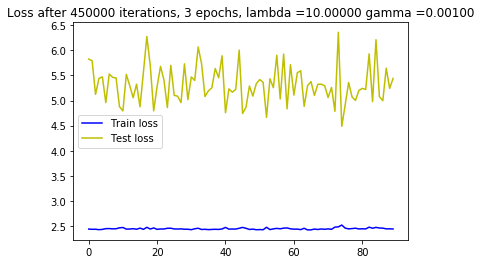

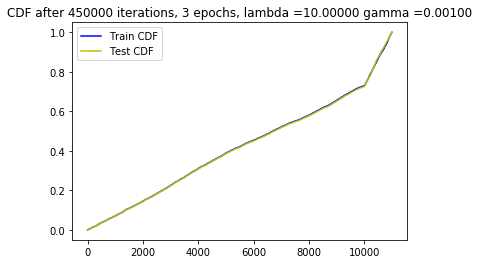

 95%|█████████▌| 450013/473047 [6:19:25<1:28:37,  4.33it/s]

New score:  0.03783644
Train score:  0.3599222
Test score:  0.32772532


 11%|█         | 49993/473047 [11:38<1:26:45, 81.27it/s] 

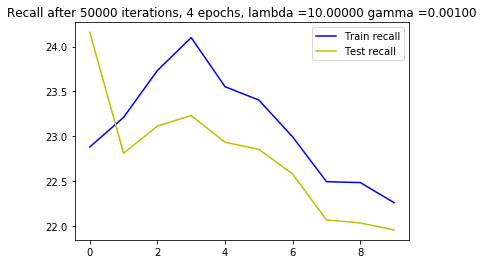

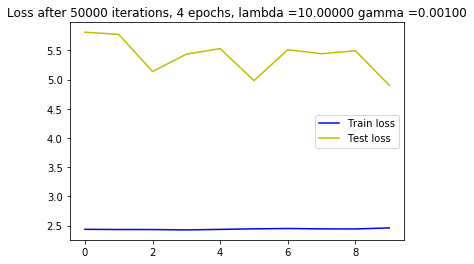

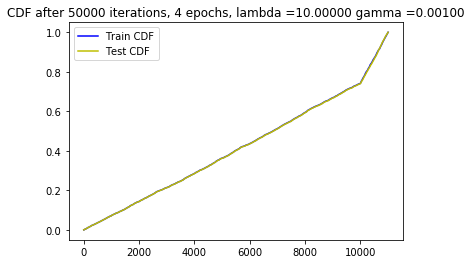

 11%|█         | 50011/473047 [11:48<27:40:32,  4.25it/s]

New score:  0.07435915
Train score:  0.26425844
Test score:  0.2675432


 21%|██        | 99998/473047 [23:07<1:06:47, 93.08it/s] 

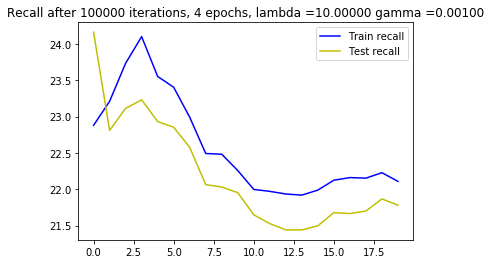

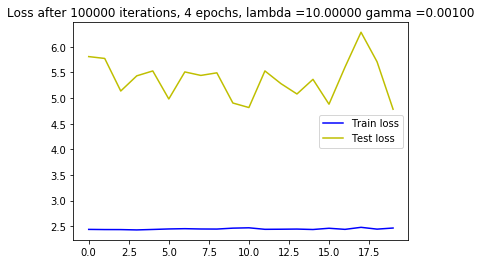

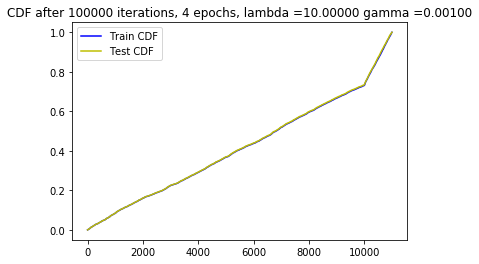

 21%|██        | 100018/473047 [23:17<21:37:40,  4.79it/s]

New score:  0.053392507
Train score:  0.31904447
Test score:  0.22144738


 32%|███▏      | 149997/473047 [34:10<57:30, 93.63it/s]   

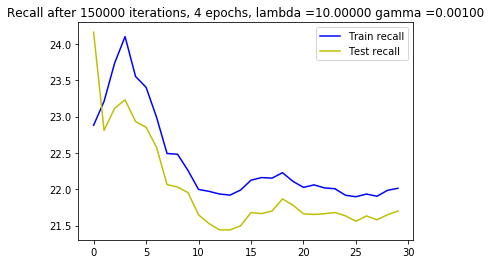

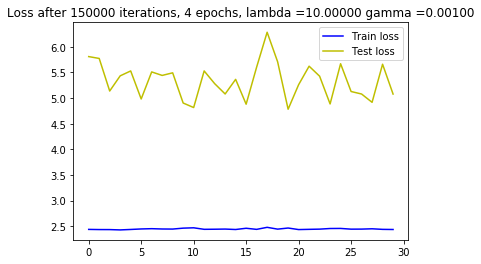

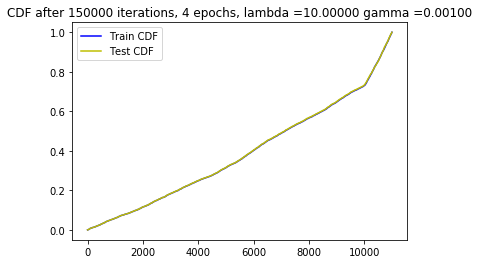

 32%|███▏      | 150017/473047 [34:20<18:31:13,  4.84it/s]

New score:  0.08494218
Train score:  0.42346102
Test score:  0.36326677


 42%|████▏     | 199998/473047 [45:45<55:26, 82.08it/s]   

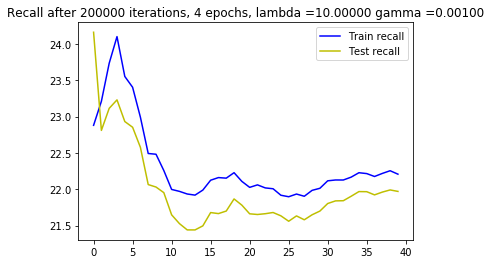

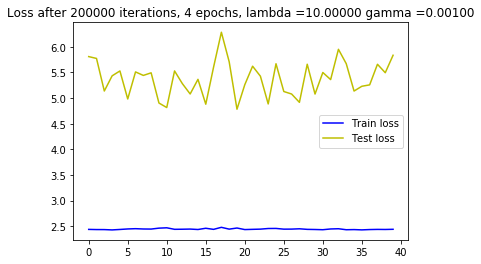

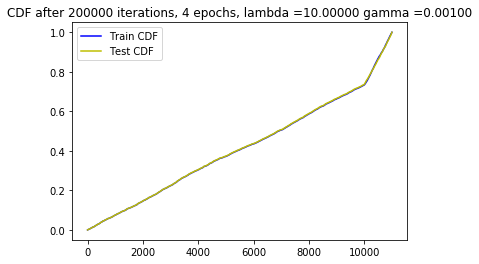

 42%|████▏     | 200016/473047 [45:54<17:31:48,  4.33it/s]

New score:  0.089500695
Train score:  0.38984972
Test score:  0.4759702


 53%|█████▎    | 249992/473047 [57:21<45:16, 82.11it/s]   

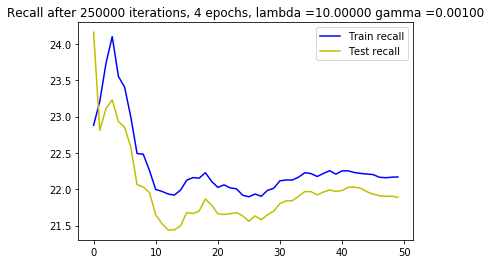

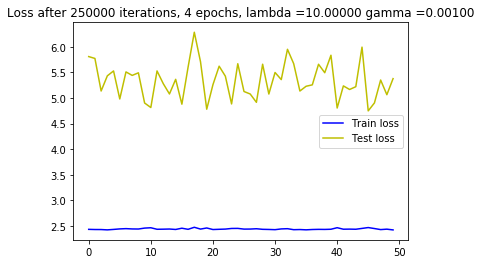

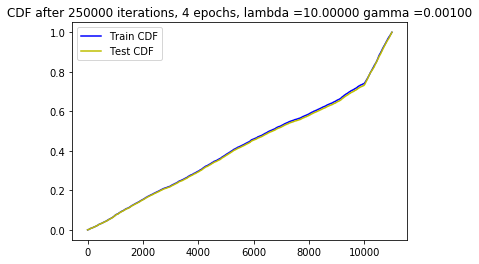

 53%|█████▎    | 250009/473047 [57:32<16:15:02,  3.81it/s]

New score:  0.13943127
Train score:  0.31047302
Test score:  0.3768701


 63%|██████▎   | 299999/473047 [1:08:58<35:05, 82.19it/s]   

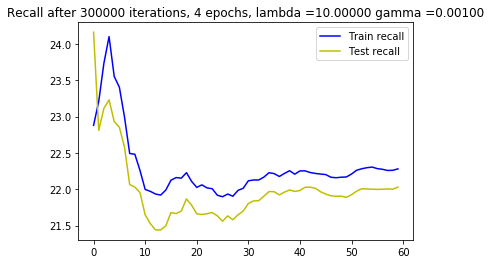

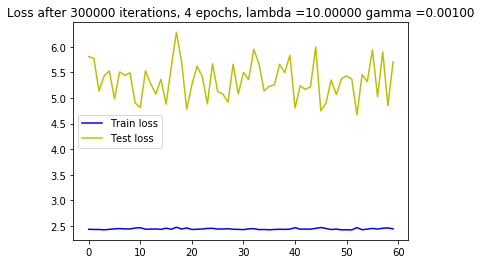

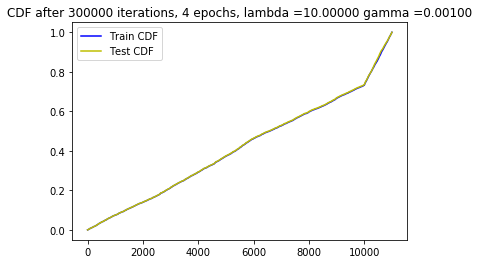

 63%|██████▎   | 300017/473047 [1:09:08<11:02:48,  4.35it/s]

New score:  0.082442254
Train score:  0.46053094
Test score:  0.43887287


 74%|███████▍  | 349997/473047 [1:20:23<24:25, 83.99it/s]   

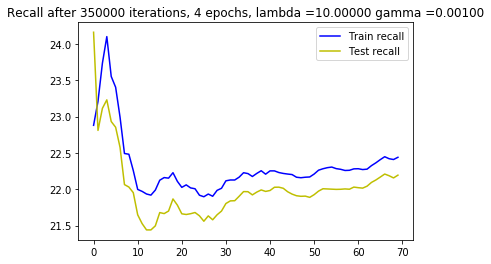

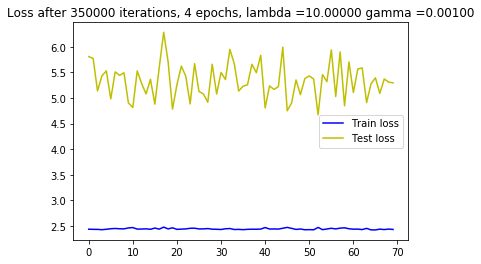

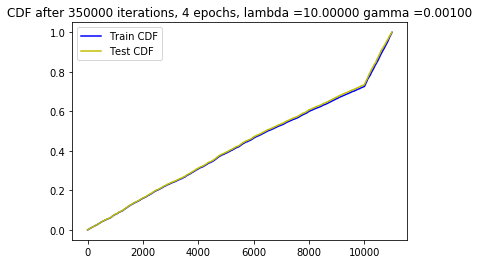

 74%|███████▍  | 350015/473047 [1:20:33<7:51:19,  4.35it/s] 

New score:  0.069863416
Train score:  0.5624059
Test score:  0.3145657


 85%|████████▍ | 400000/473047 [1:31:59<15:04, 80.77it/s]   

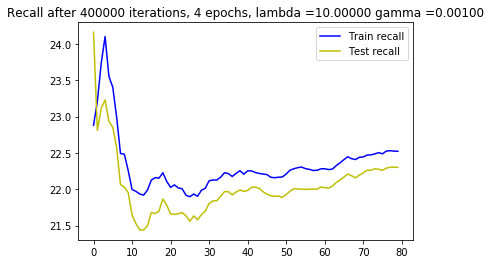

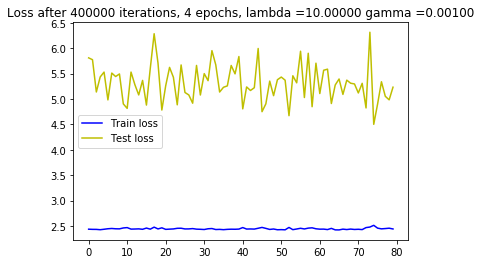

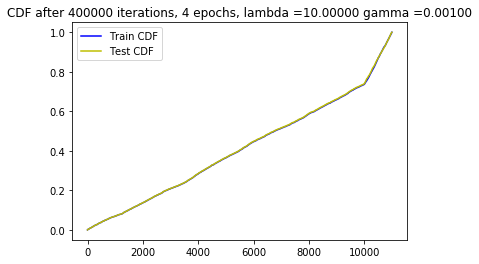

 85%|████████▍ | 400009/473047 [1:32:09<6:39:46,  3.05it/s]

New score:  0.070462056
Train score:  0.40813485
Test score:  0.24565724


 95%|█████████▌| 449998/473047 [1:43:41<04:42, 81.52it/s]  

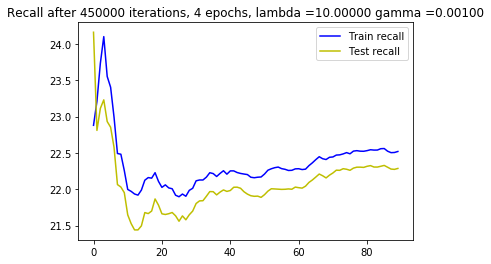

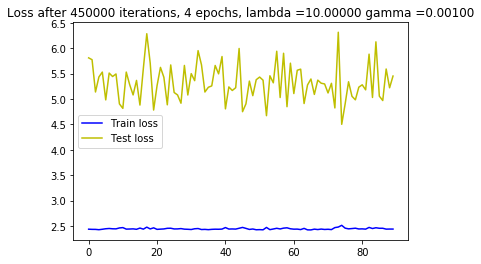

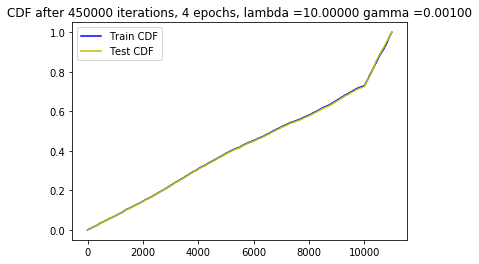

 95%|█████████▌| 450016/473047 [1:43:51<1:28:38,  4.33it/s]

New score:  0.03722477
Train score:  0.37408167
Test score:  0.33467364


 11%|█         | 49999/473047 [11:17<1:26:29, 81.51it/s] 

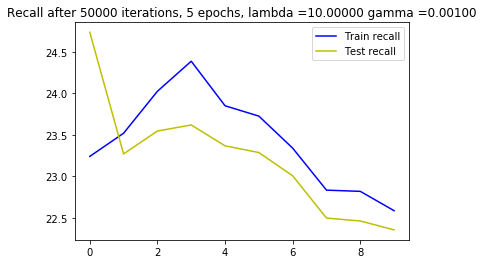

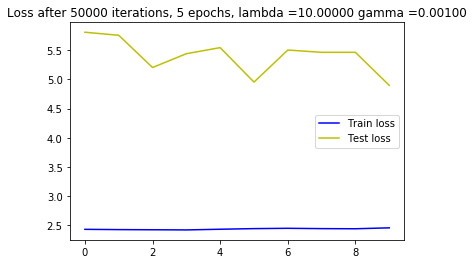

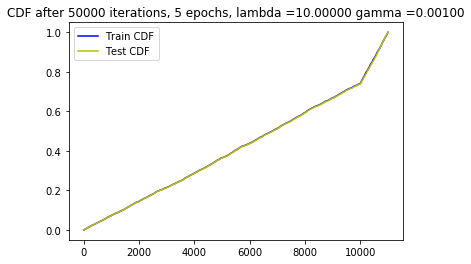

 11%|█         | 50017/473047 [11:26<27:07:11,  4.33it/s]

New score:  0.07400435
Train score:  0.26214942
Test score:  0.26932177


 21%|██        | 100000/473047 [23:01<1:15:49, 81.99it/s]

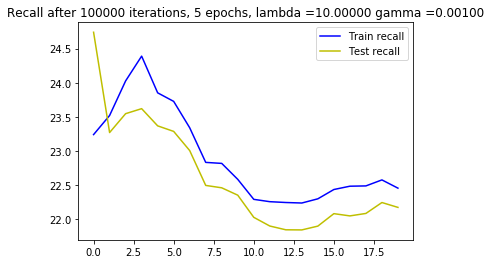

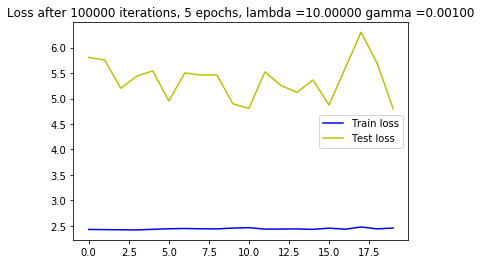

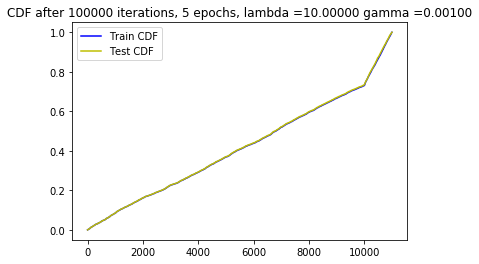

 21%|██        | 100009/473047 [23:10<33:34:08,  3.09it/s]

New score:  0.05514314
Train score:  0.3177163
Test score:  0.23052335


 32%|███▏      | 149999/473047 [34:42<1:05:45, 81.87it/s] 

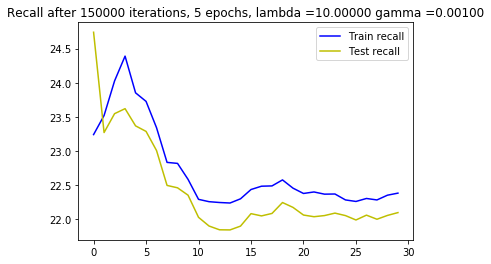

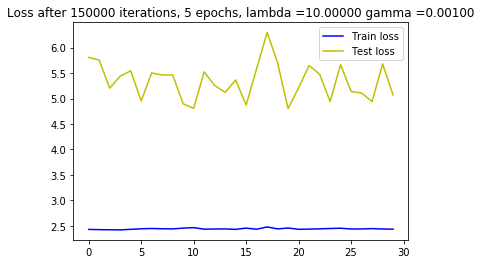

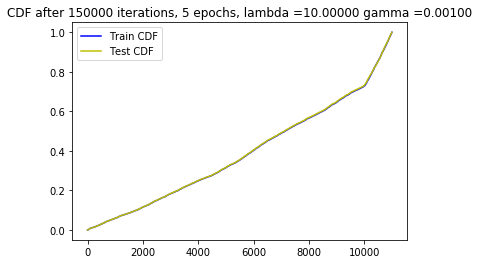

 32%|███▏      | 150017/473047 [34:52<20:21:24,  4.41it/s]

New score:  0.08566164
Train score:  0.42067677
Test score:  0.35938653


 42%|████▏     | 199997/473047 [45:55<55:36, 81.83it/s]   

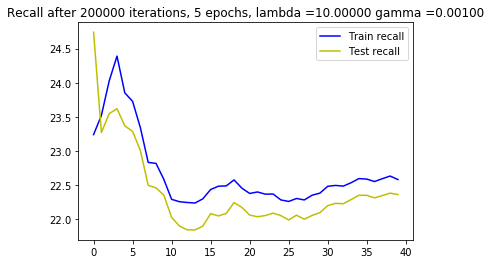

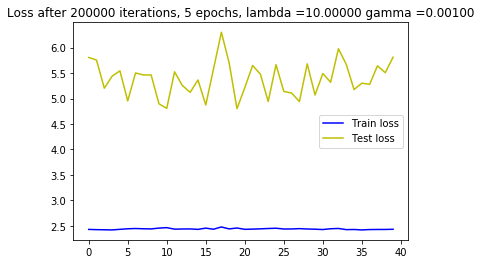

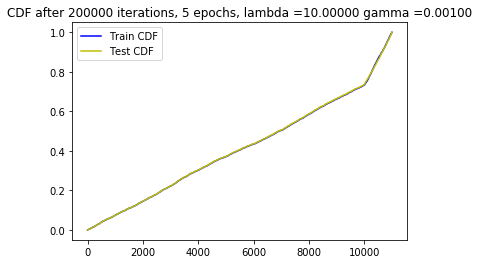

 42%|████▏     | 200015/473047 [46:05<17:29:06,  4.34it/s]

New score:  0.089919746
Train score:  0.38498598
Test score:  0.47657388


 53%|█████▎    | 249994/473047 [57:00<39:50, 93.29it/s]   

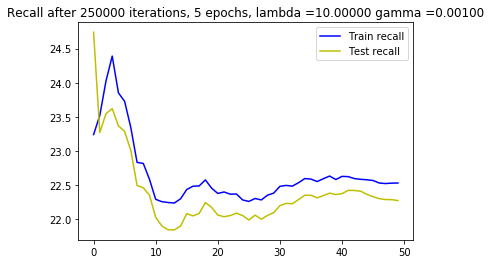

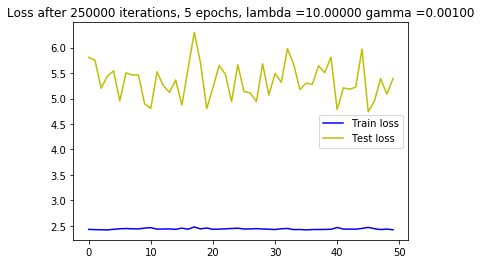

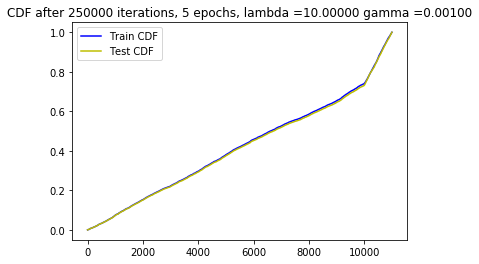

 53%|█████▎    | 250014/473047 [57:10<12:49:53,  4.83it/s]

New score:  0.1383547
Train score:  0.31063497
Test score:  0.38365018


 63%|██████▎   | 299992/473047 [1:08:29<35:16, 81.77it/s]   

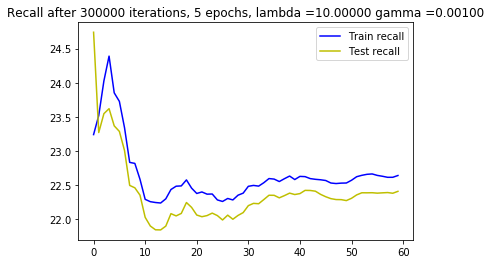

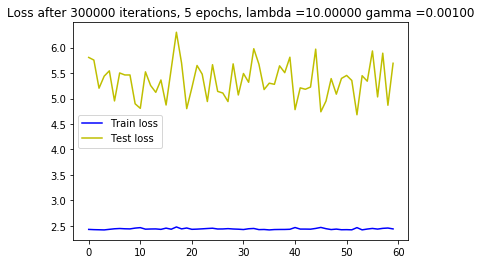

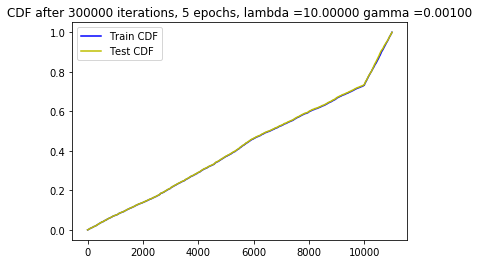

 63%|██████▎   | 300010/473047 [1:08:39<11:04:56,  4.34it/s]

New score:  0.08104208
Train score:  0.4585425
Test score:  0.43957335


 74%|███████▍  | 350000/473047 [1:20:11<24:21, 84.21it/s]   

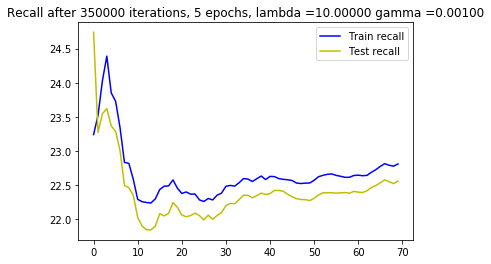

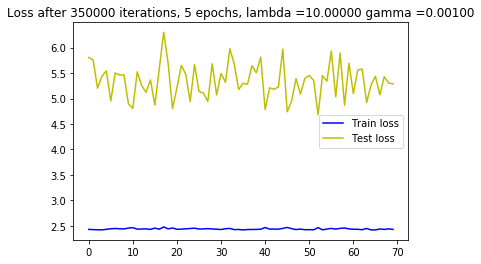

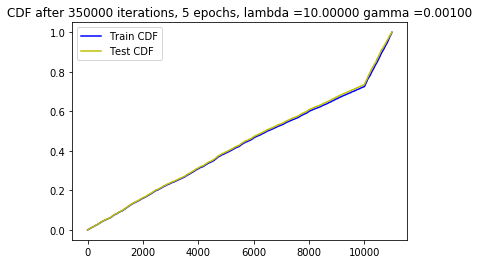

 74%|███████▍  | 350009/473047 [1:20:20<10:51:11,  3.15it/s]

New score:  0.07004285
Train score:  0.57174855
Test score:  0.3080098


 85%|████████▍ | 399996/473047 [1:31:36<14:59, 81.19it/s]   

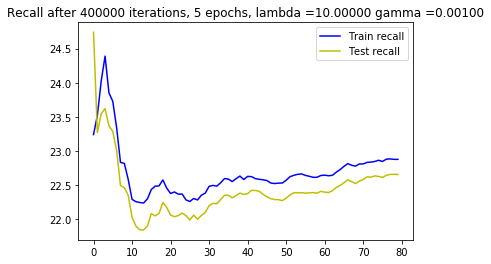

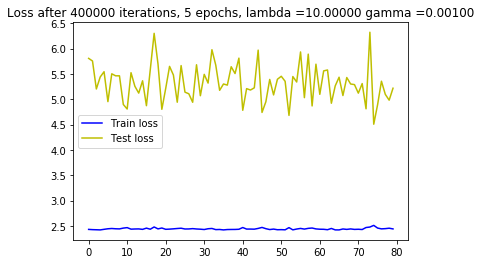

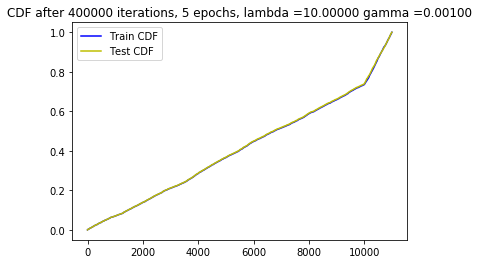

 85%|████████▍ | 400014/473047 [1:31:46<4:42:44,  4.30it/s]

New score:  0.07097599
Train score:  0.41303572
Test score:  0.2489675


 95%|█████████▌| 449999/473047 [1:43:24<04:42, 81.50it/s]  

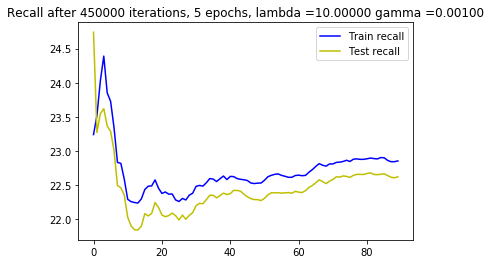

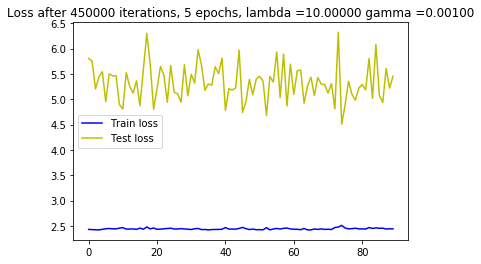

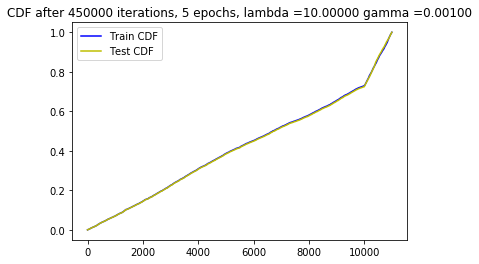

 95%|█████████▌| 450017/473047 [1:43:34<1:28:21,  4.34it/s]

New score:  0.0382902
Train score:  0.36857376
Test score:  0.33198974


 11%|█         | 49998/473047 [11:29<1:25:43, 82.25it/s] 

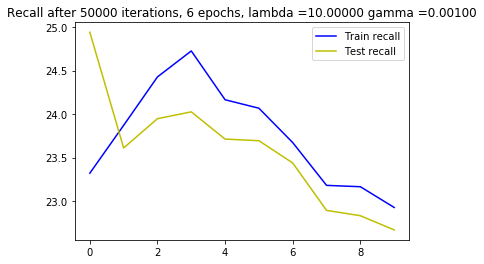

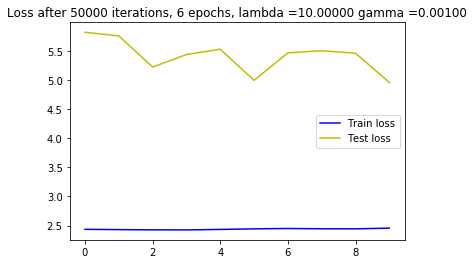

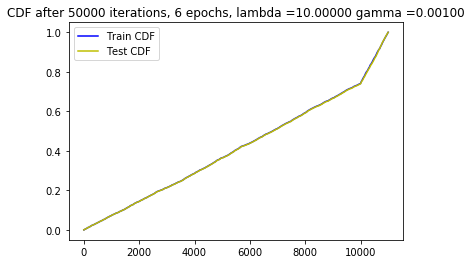

 11%|█         | 50015/473047 [11:39<27:18:21,  4.30it/s]

New score:  0.07387748
Train score:  0.27459627
Test score:  0.2707278


 21%|██        | 99996/473047 [23:07<1:15:56, 81.87it/s] 

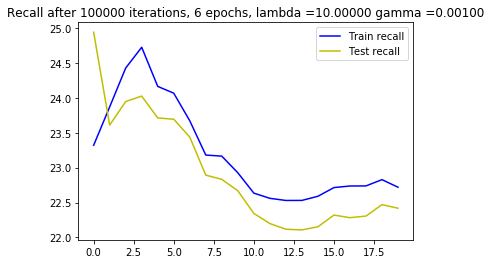

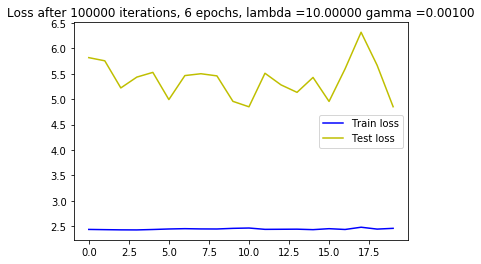

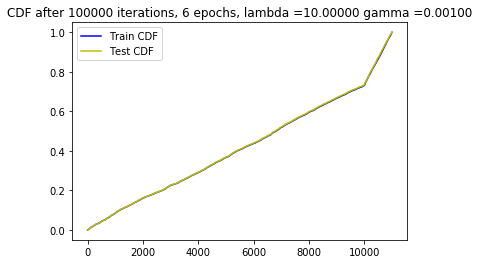

 21%|██        | 100014/473047 [23:17<23:40:17,  4.38it/s]

New score:  0.055494826
Train score:  0.3203251
Test score:  0.237645


 32%|███▏      | 149994/473047 [34:40<1:04:56, 82.91it/s] 

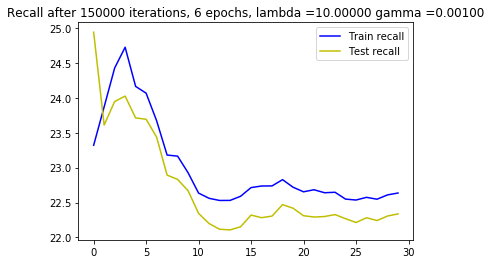

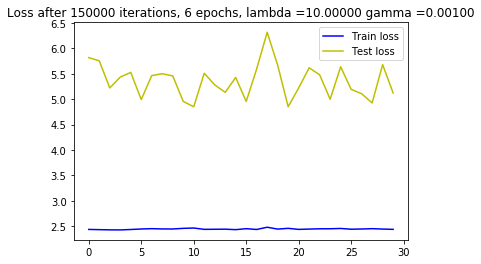

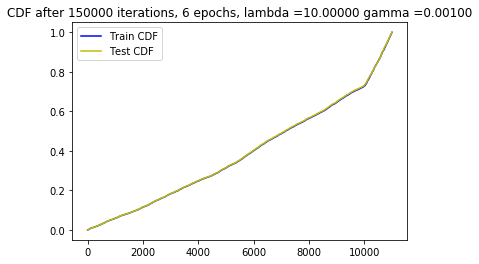

 32%|███▏      | 150012/473047 [34:49<20:08:58,  4.45it/s]

New score:  0.08562982
Train score:  0.42299256
Test score:  0.3630309


 42%|████▏     | 199999/473047 [45:15<57:54, 78.59it/s]   

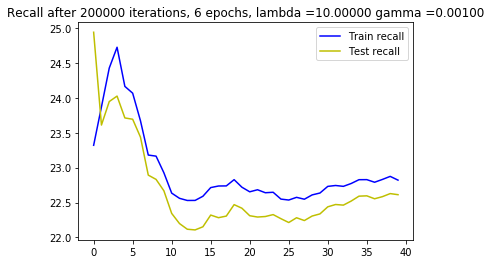

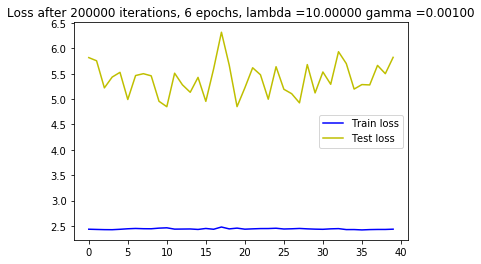

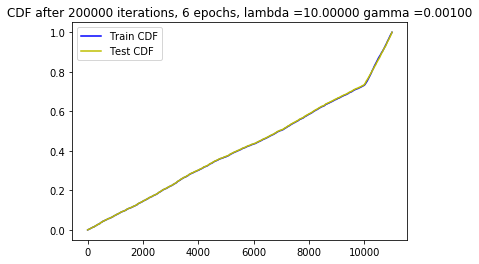

 42%|████▏     | 200016/473047 [45:24<19:23:41,  3.91it/s]

New score:  0.09232752
Train score:  0.38532442
Test score:  0.47333726


 53%|█████▎    | 250000/473047 [56:49<45:23, 81.91it/s]   

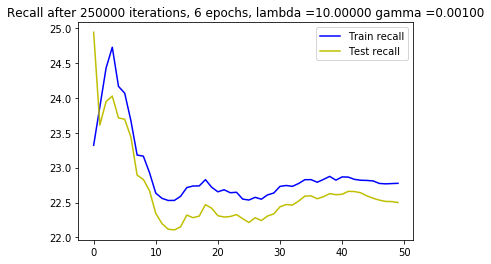

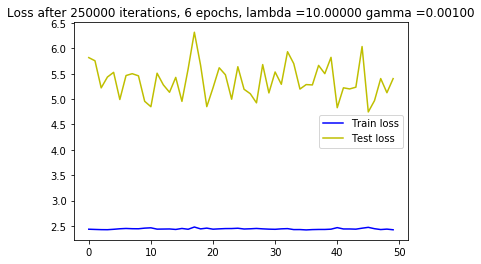

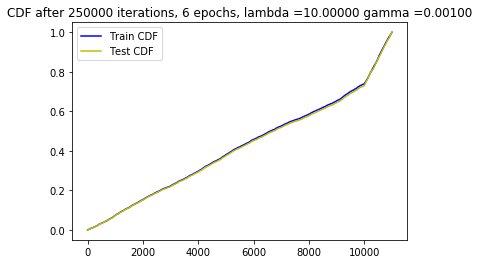

 53%|█████▎    | 250009/473047 [56:58<19:59:19,  3.10it/s]

New score:  0.13716929
Train score:  0.312706
Test score:  0.37885466


 63%|██████▎   | 300000/473047 [1:08:25<35:24, 81.46it/s]   

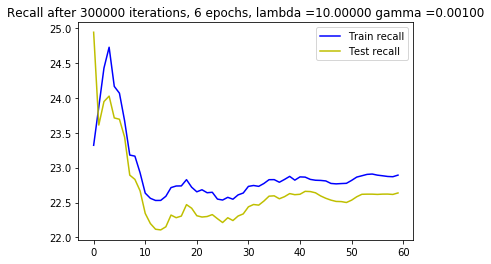

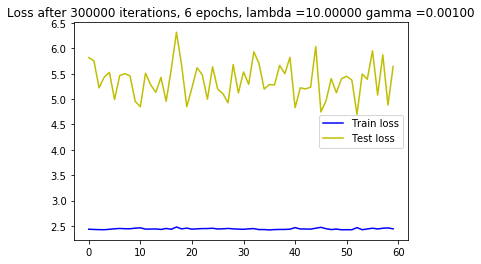

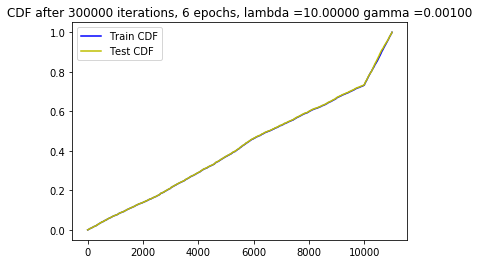

 63%|██████▎   | 300009/473047 [1:08:34<15:42:26,  3.06it/s]

New score:  0.07764493
Train score:  0.4551205
Test score:  0.43396217


 74%|███████▍  | 349995/473047 [1:20:05<24:54, 82.34it/s]   

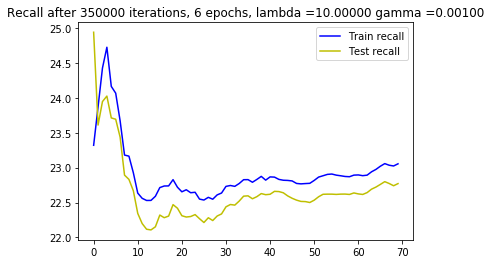

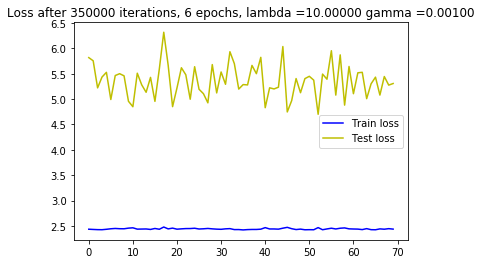

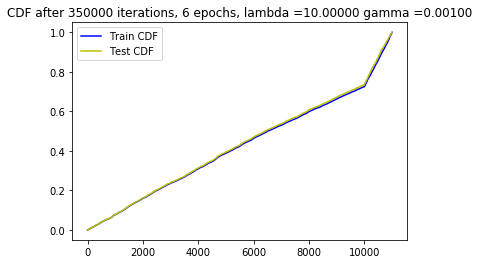

 74%|███████▍  | 350013/473047 [1:20:15<7:45:41,  4.40it/s] 

New score:  0.07008158
Train score:  0.5751239
Test score:  0.30919987


 85%|████████▍ | 399997/473047 [1:31:41<14:47, 82.33it/s]  

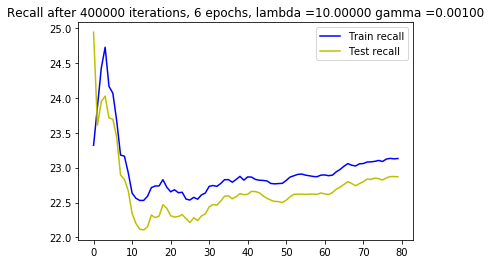

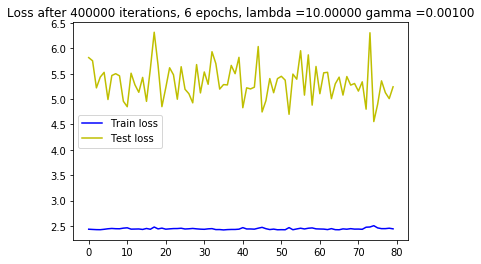

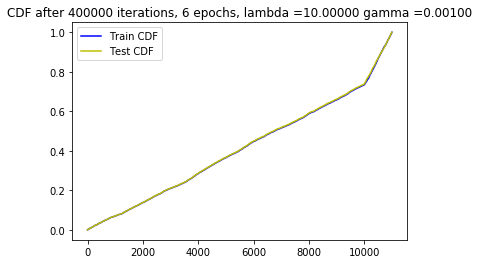

 85%|████████▍ | 400015/473047 [1:31:50<4:36:51,  4.40it/s]

New score:  0.074249916
Train score:  0.41642898
Test score:  0.24844392


 95%|█████████▌| 449992/473047 [1:43:24<04:42, 81.51it/s]  

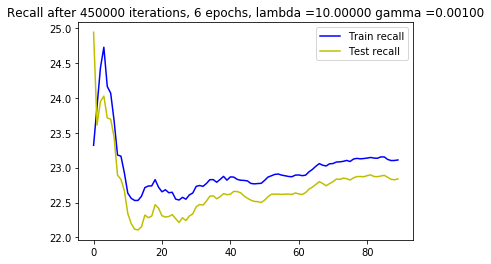

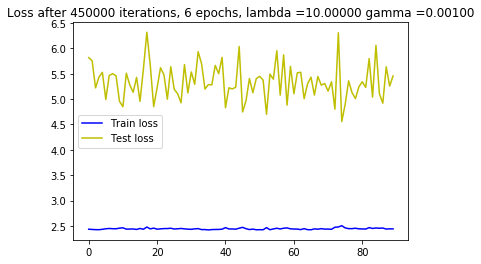

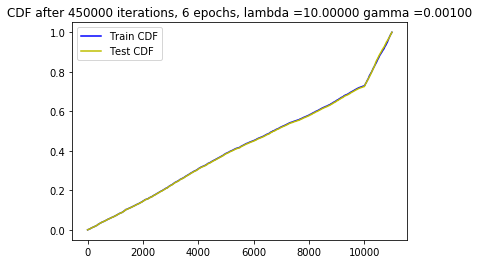

 95%|█████████▌| 450009/473047 [1:43:33<1:28:39,  4.33it/s]

New score:  0.03757117
Train score:  0.37392145
Test score:  0.338924


 11%|█         | 49994/473047 [11:38<1:25:27, 82.50it/s] 

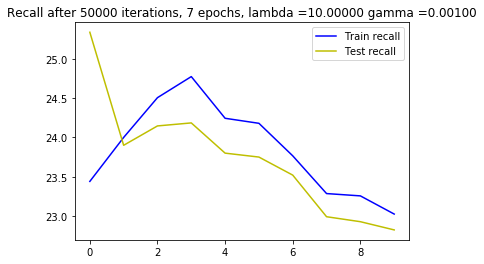

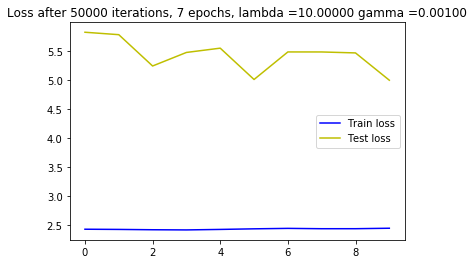

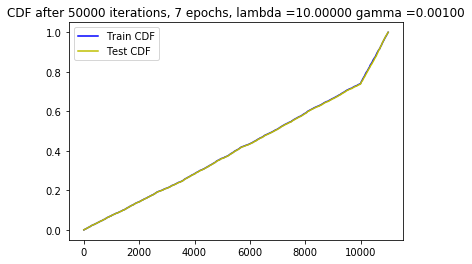

 11%|█         | 50012/473047 [11:48<27:27:15,  4.28it/s]

New score:  0.074414164
Train score:  0.27818713
Test score:  0.28218675


 21%|██        | 100000/473047 [23:16<1:15:08, 82.75it/s]

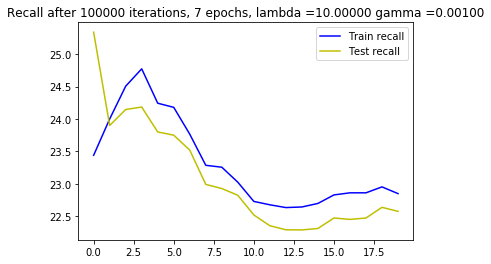

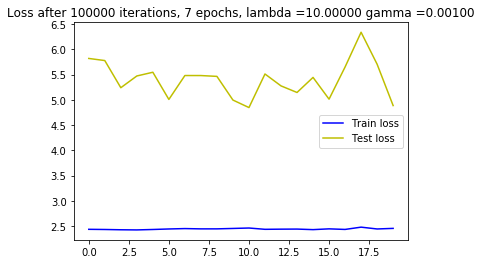

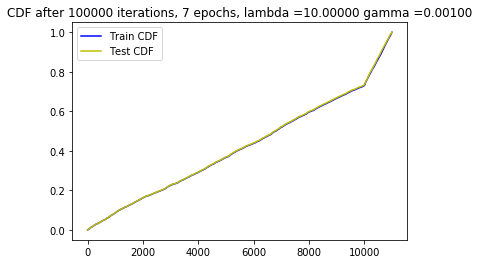

 21%|██        | 100009/473047 [23:25<33:09:49,  3.12it/s]

New score:  0.056809794
Train score:  0.32615316
Test score:  0.24939206


 32%|███▏      | 149996/473047 [35:55<1:14:28, 72.30it/s] 

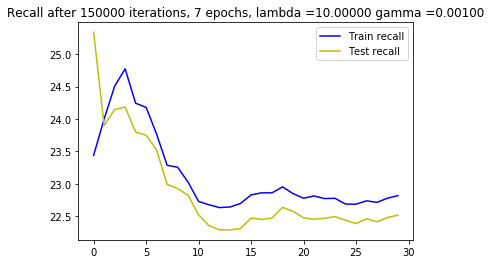

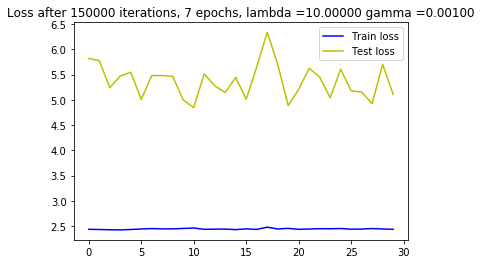

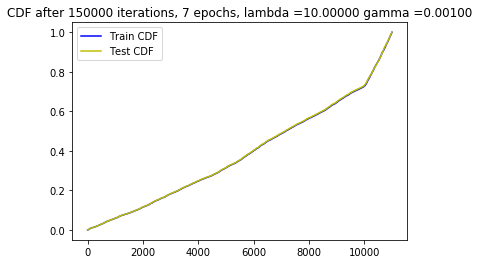

 32%|███▏      | 150012/473047 [36:05<25:30:04,  3.52it/s]

New score:  0.08580441
Train score:  0.4216544
Test score:  0.36089873


 42%|████▏     | 199998/473047 [48:50<1:03:53, 71.24it/s] 

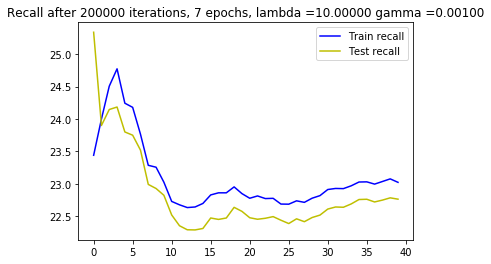

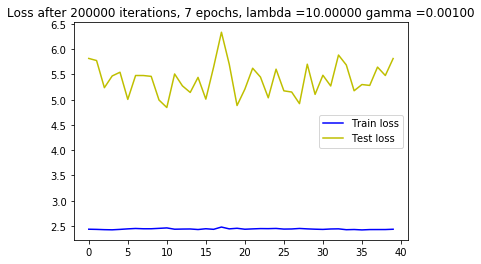

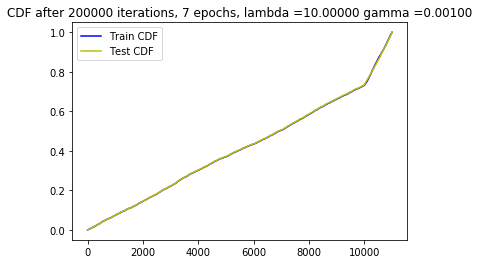

 42%|████▏     | 200014/473047 [49:02<25:20:07,  2.99it/s]

New score:  0.094755
Train score:  0.3933645
Test score:  0.47642365


 53%|█████▎    | 249996/473047 [1:02:05<51:09, 72.67it/s]   

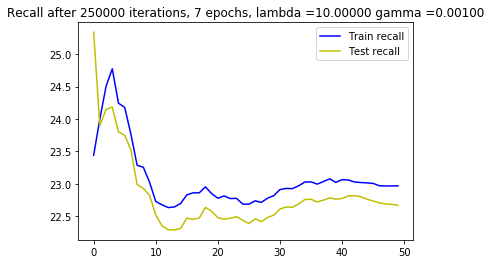

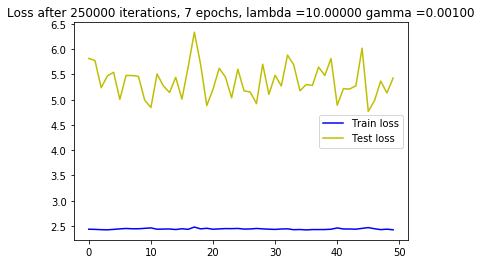

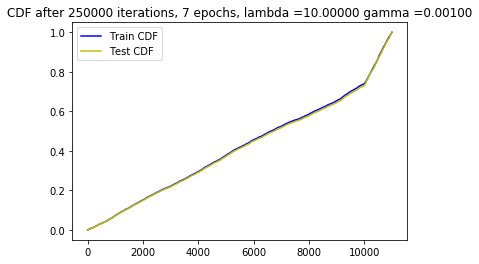

 53%|█████▎    | 250012/473047 [1:02:16<17:47:29,  3.48it/s]

New score:  0.13937968
Train score:  0.31560805
Test score:  0.3818045


 63%|██████▎   | 299998/473047 [1:15:02<39:15, 73.46it/s]   

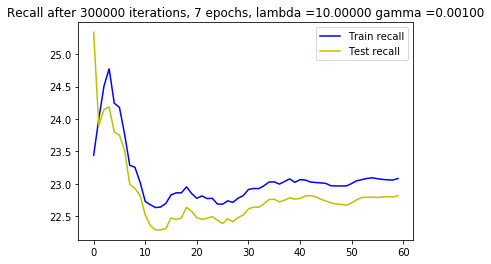

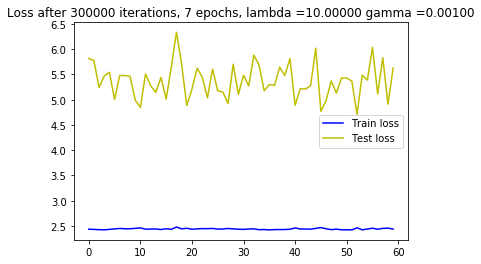

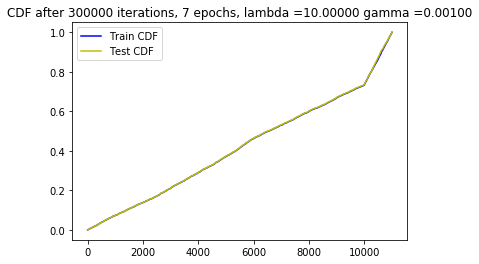

 63%|██████▎   | 300014/473047 [1:15:12<13:37:53,  3.53it/s]

New score:  0.07756741
Train score:  0.45710737
Test score:  0.43287674


 73%|███████▎  | 347316/473047 [1:27:30<28:18, 74.01it/s]   

In [ ]:
for g in range(len(gammas)):
    for l in range(len(lambdas)):
        model = SimpleConvNet()
        model.apply(weights_init)
        model.cuda()
        sgd(gamma=gammas[g], lamb=lambdas[l])

In [ ]:
# for g in range(len(gammas)):
#     for l in range(len(lambdas)):
#         model = SimpleConvNet()
#         optim = SGD(model.parameters(), lr=gamma)
#         checkpoint = torch.load('../models/model.pth')
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         epoch = checkpoint['epoch']
#         model.to(device)
#         sgd(gamma=gammas[g], lamb=lambdas[l])        